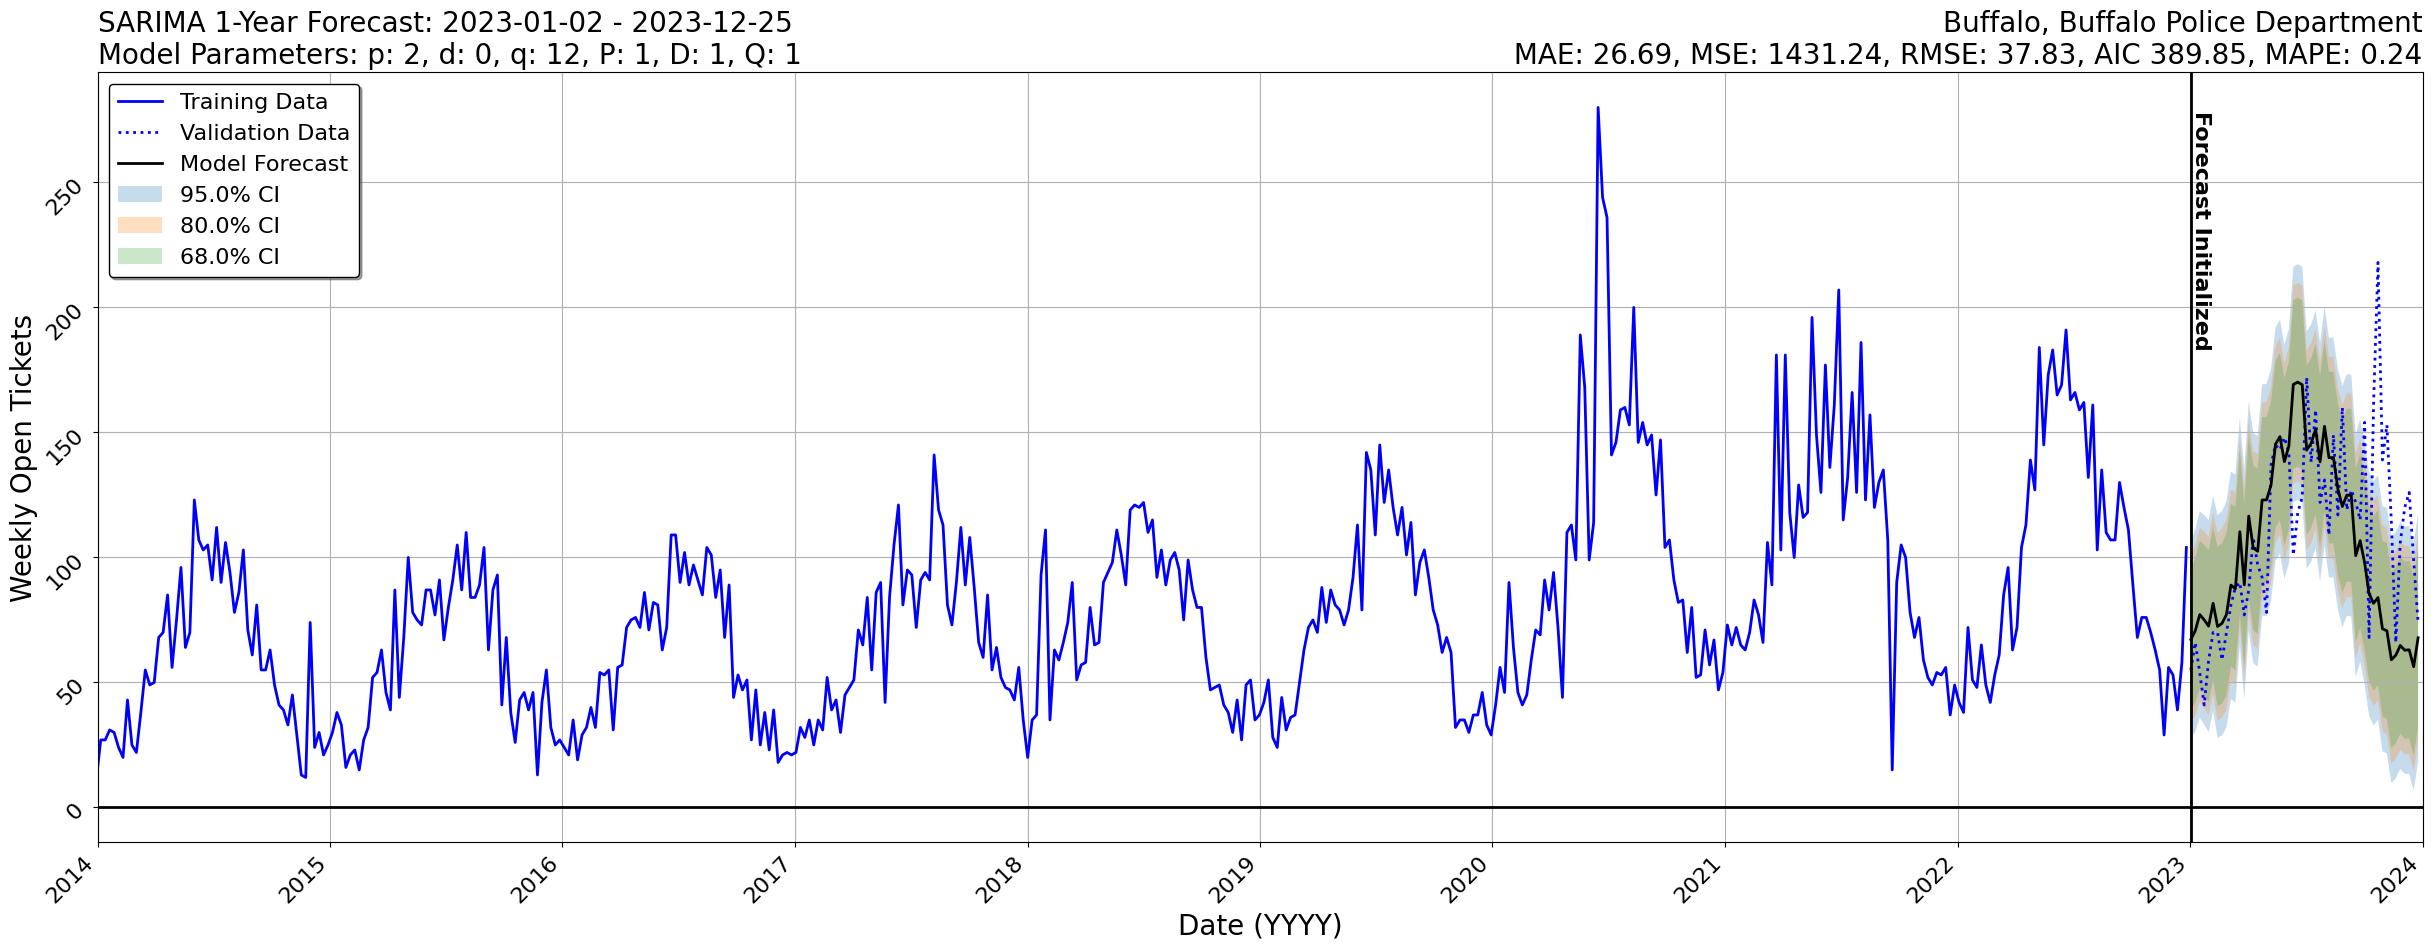

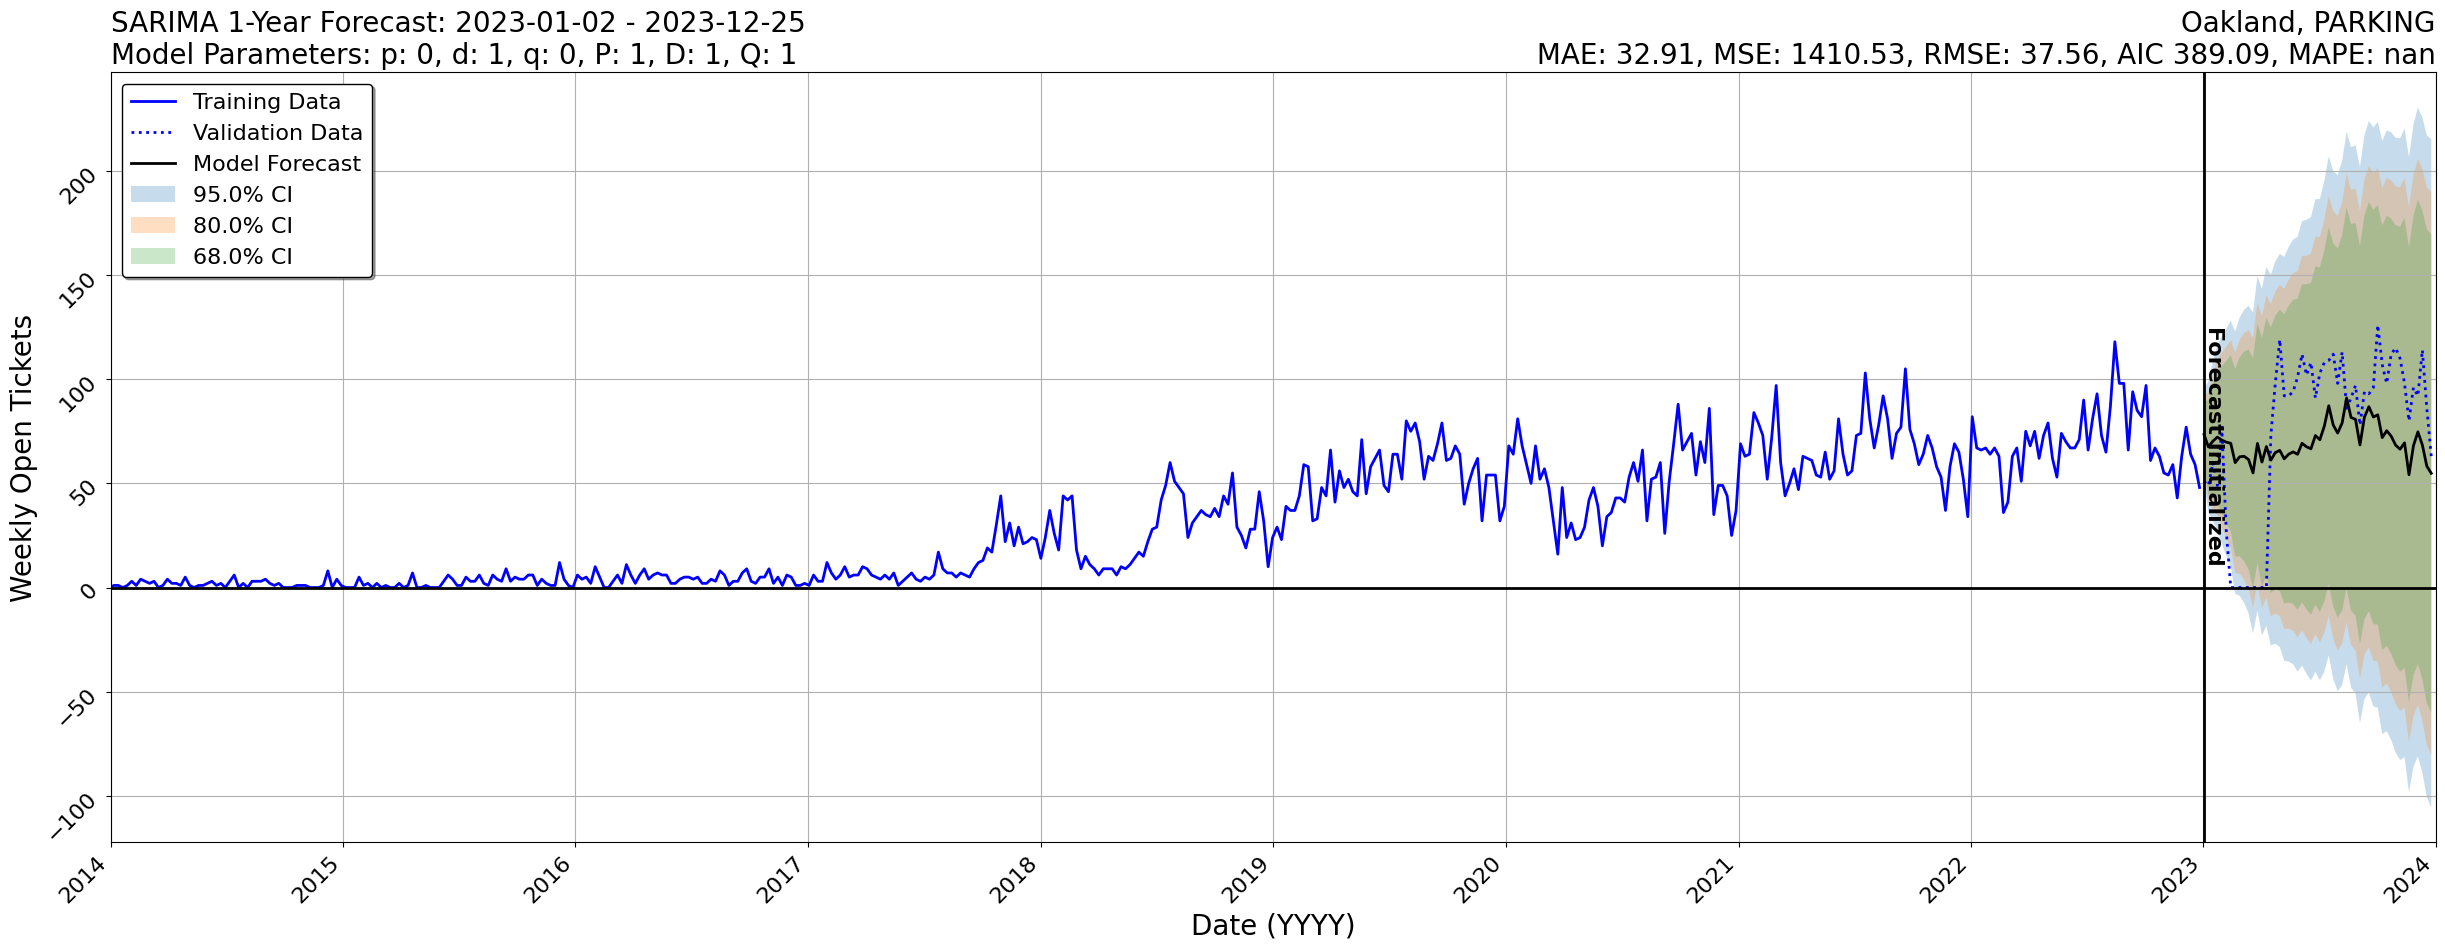

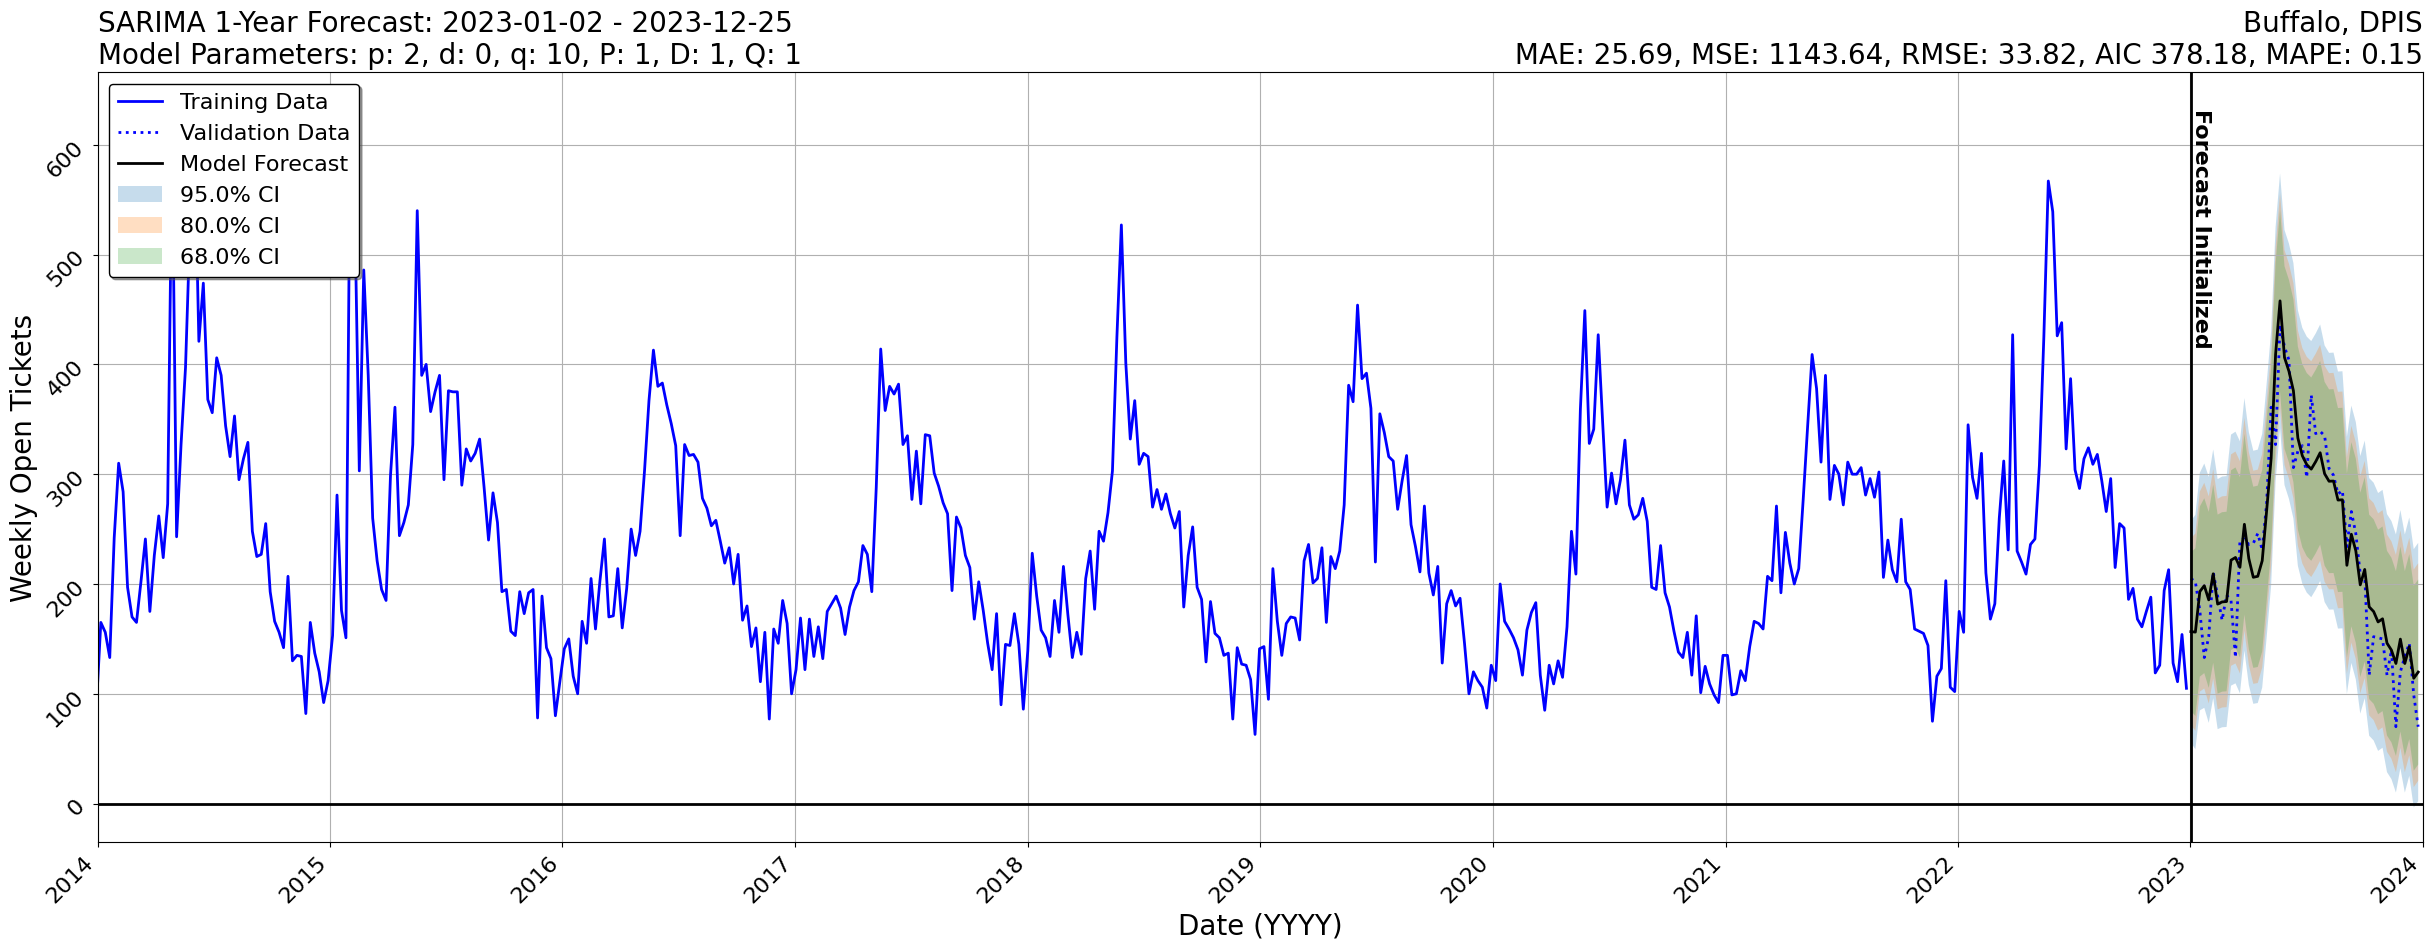

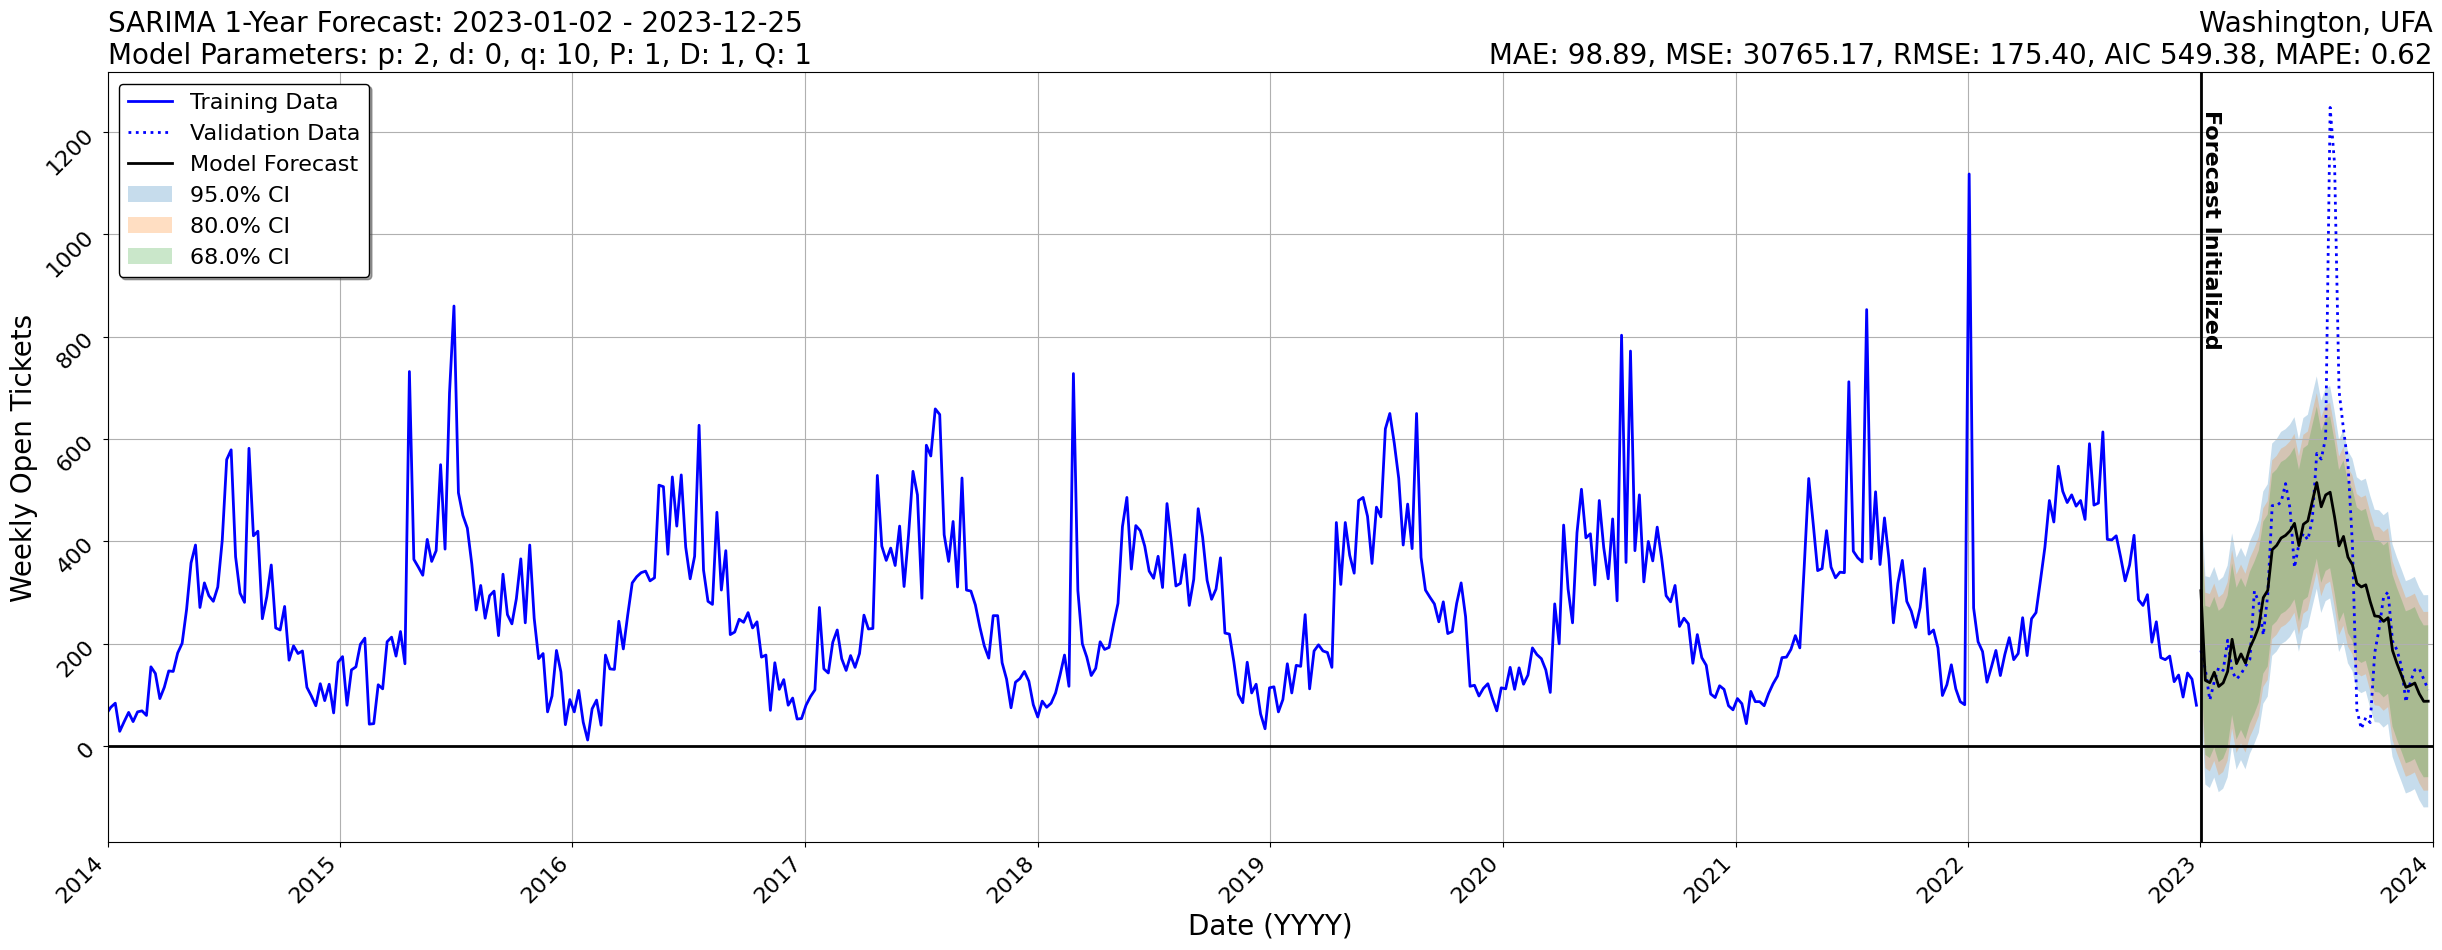

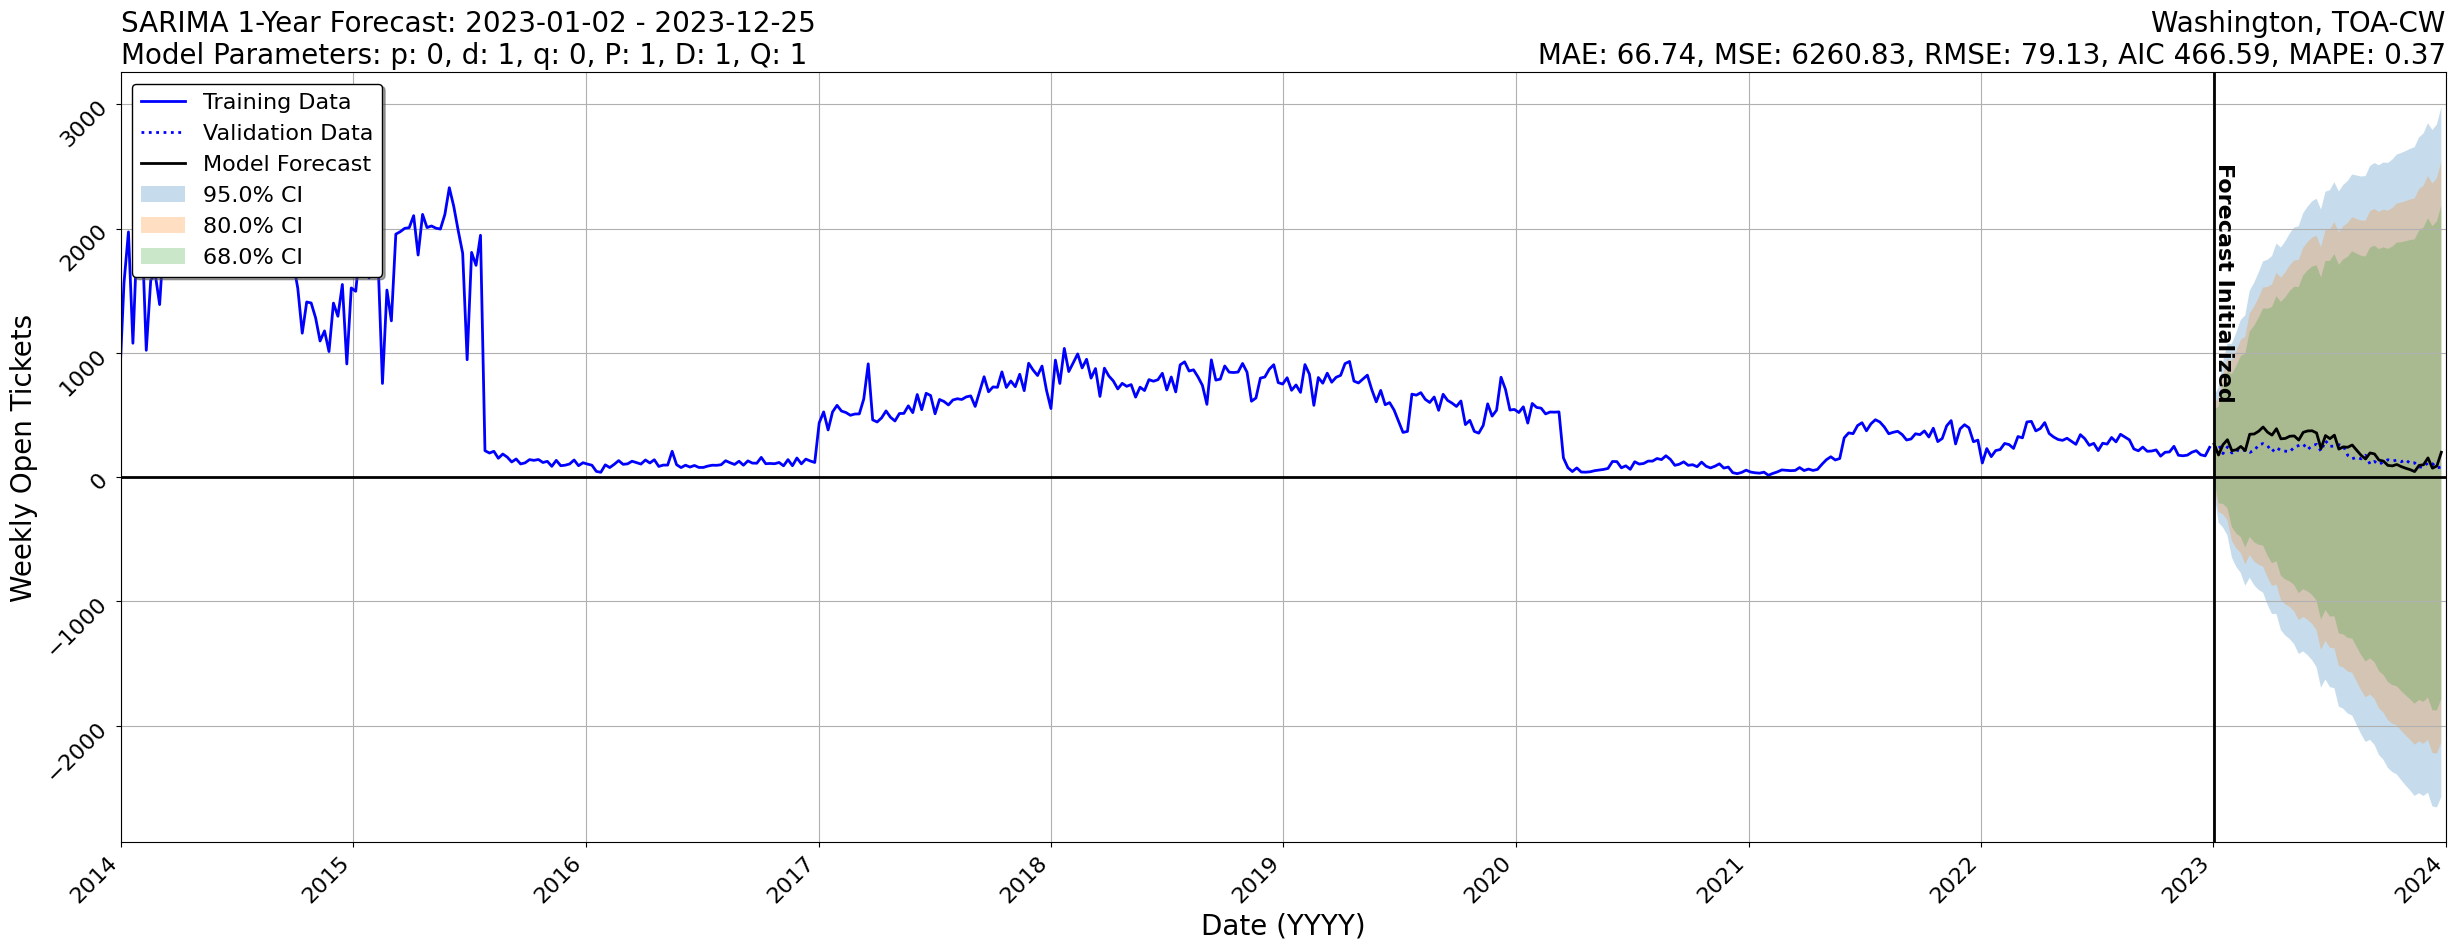

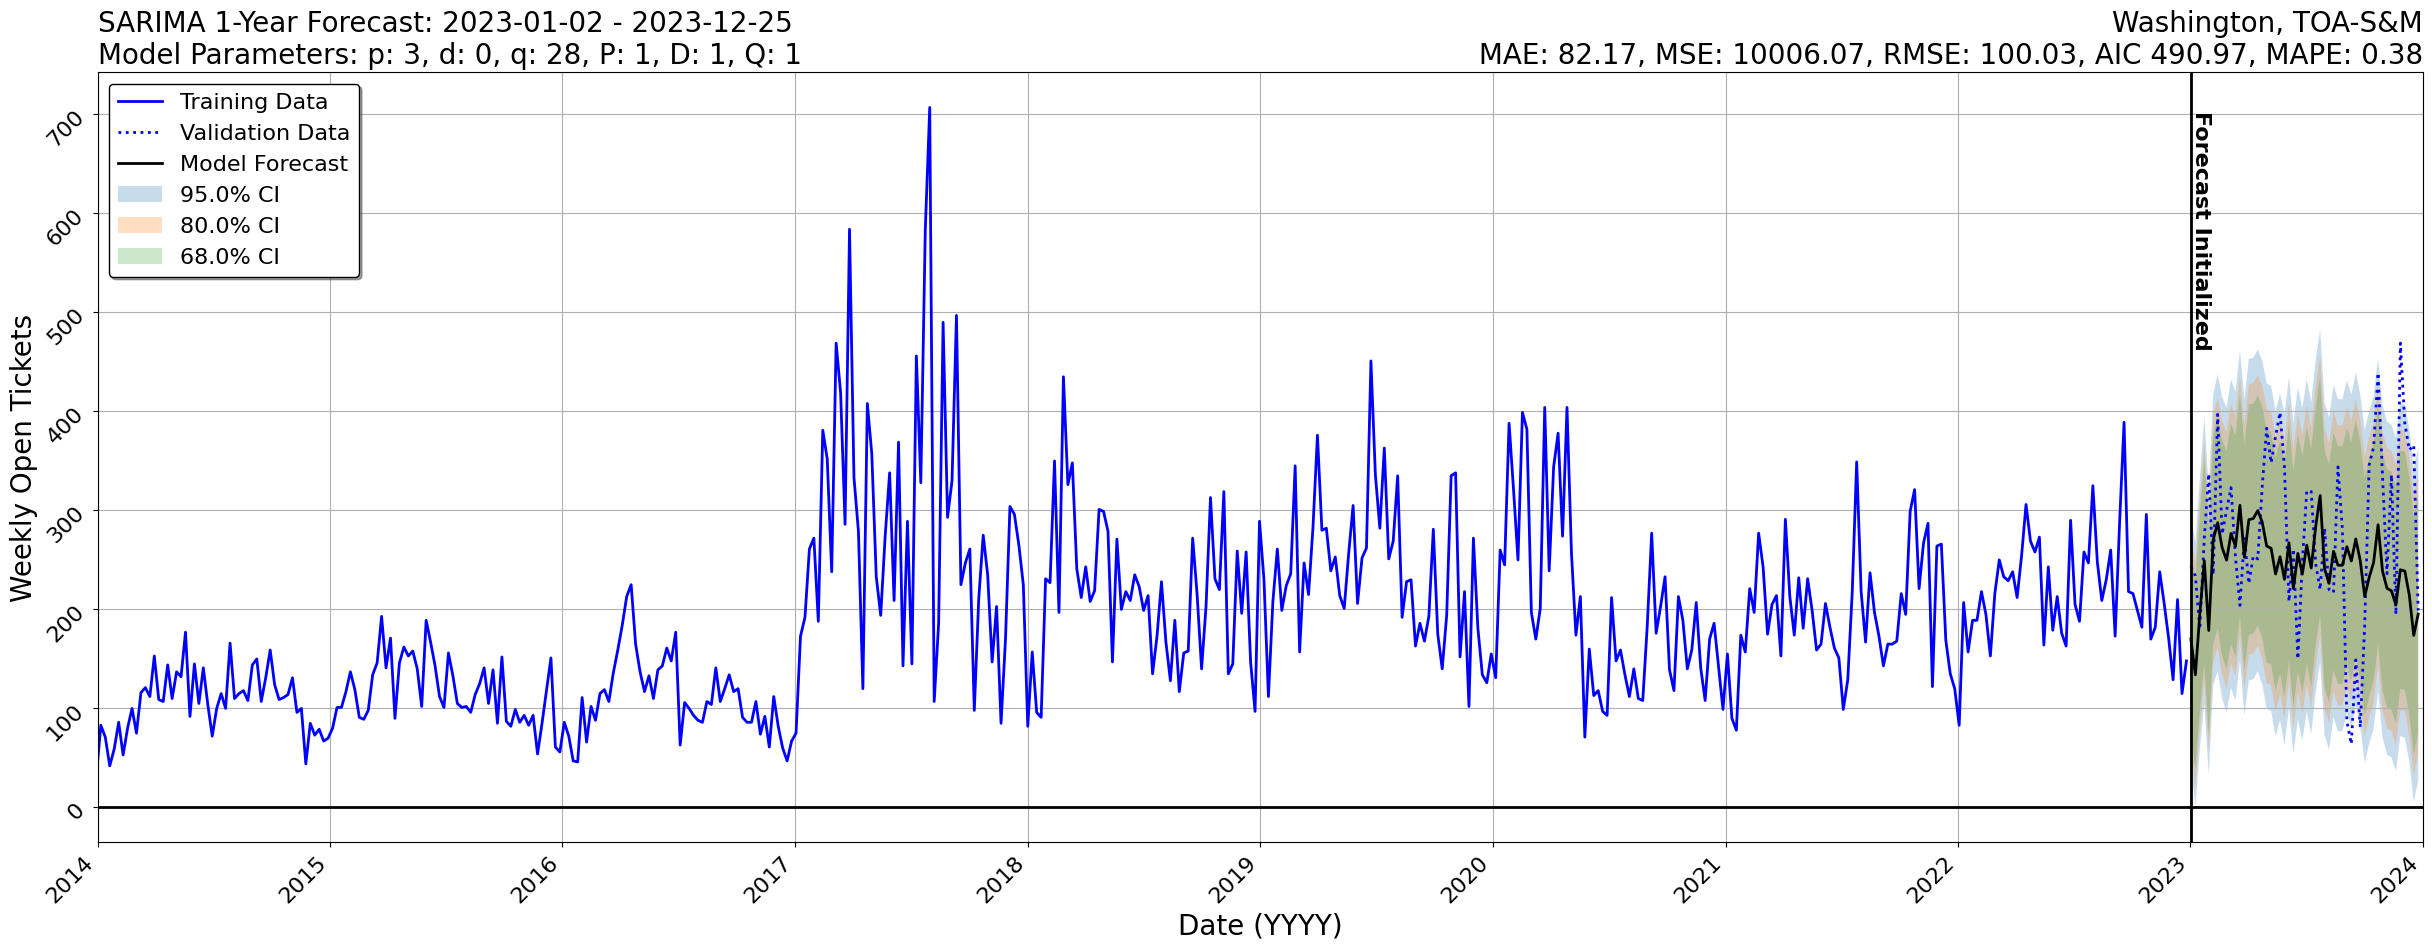

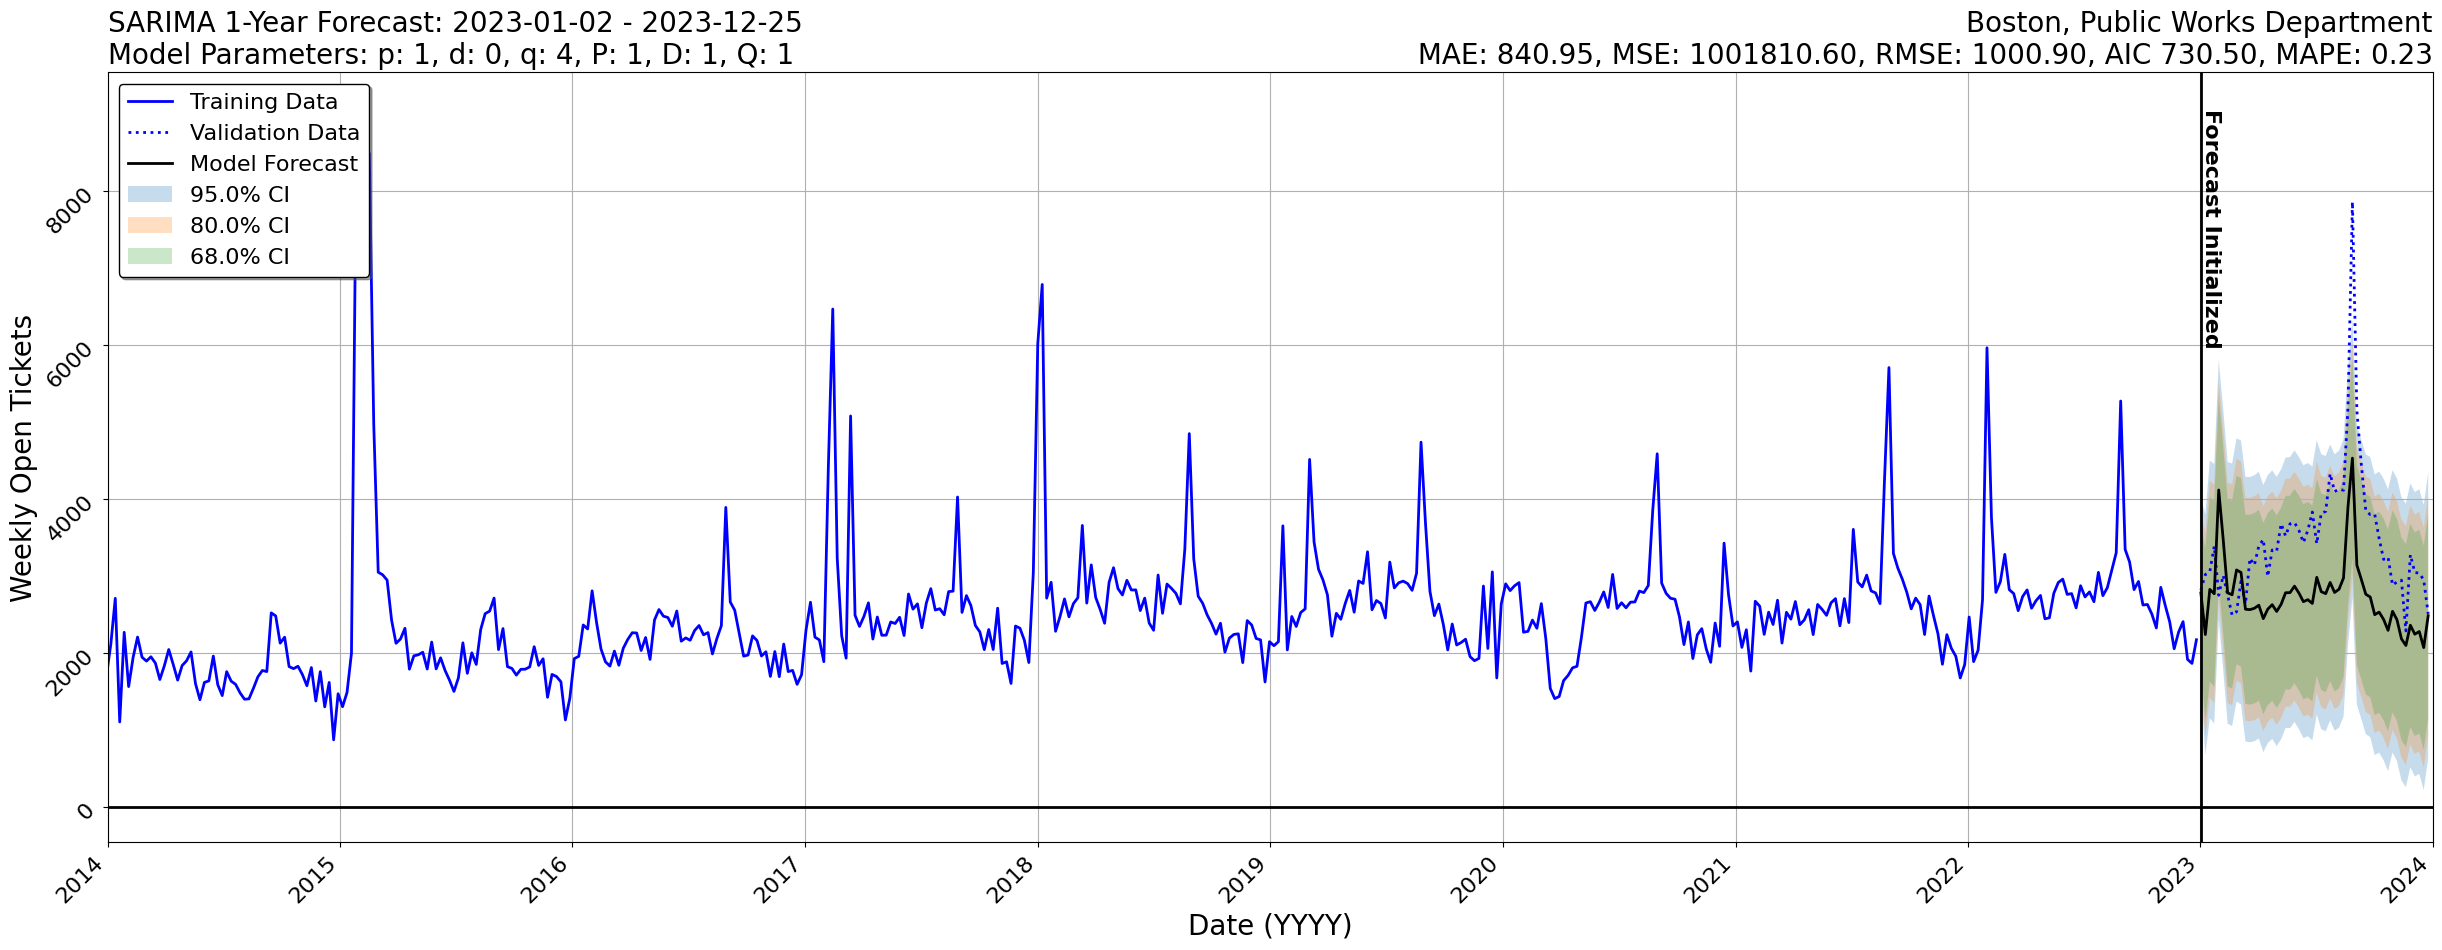

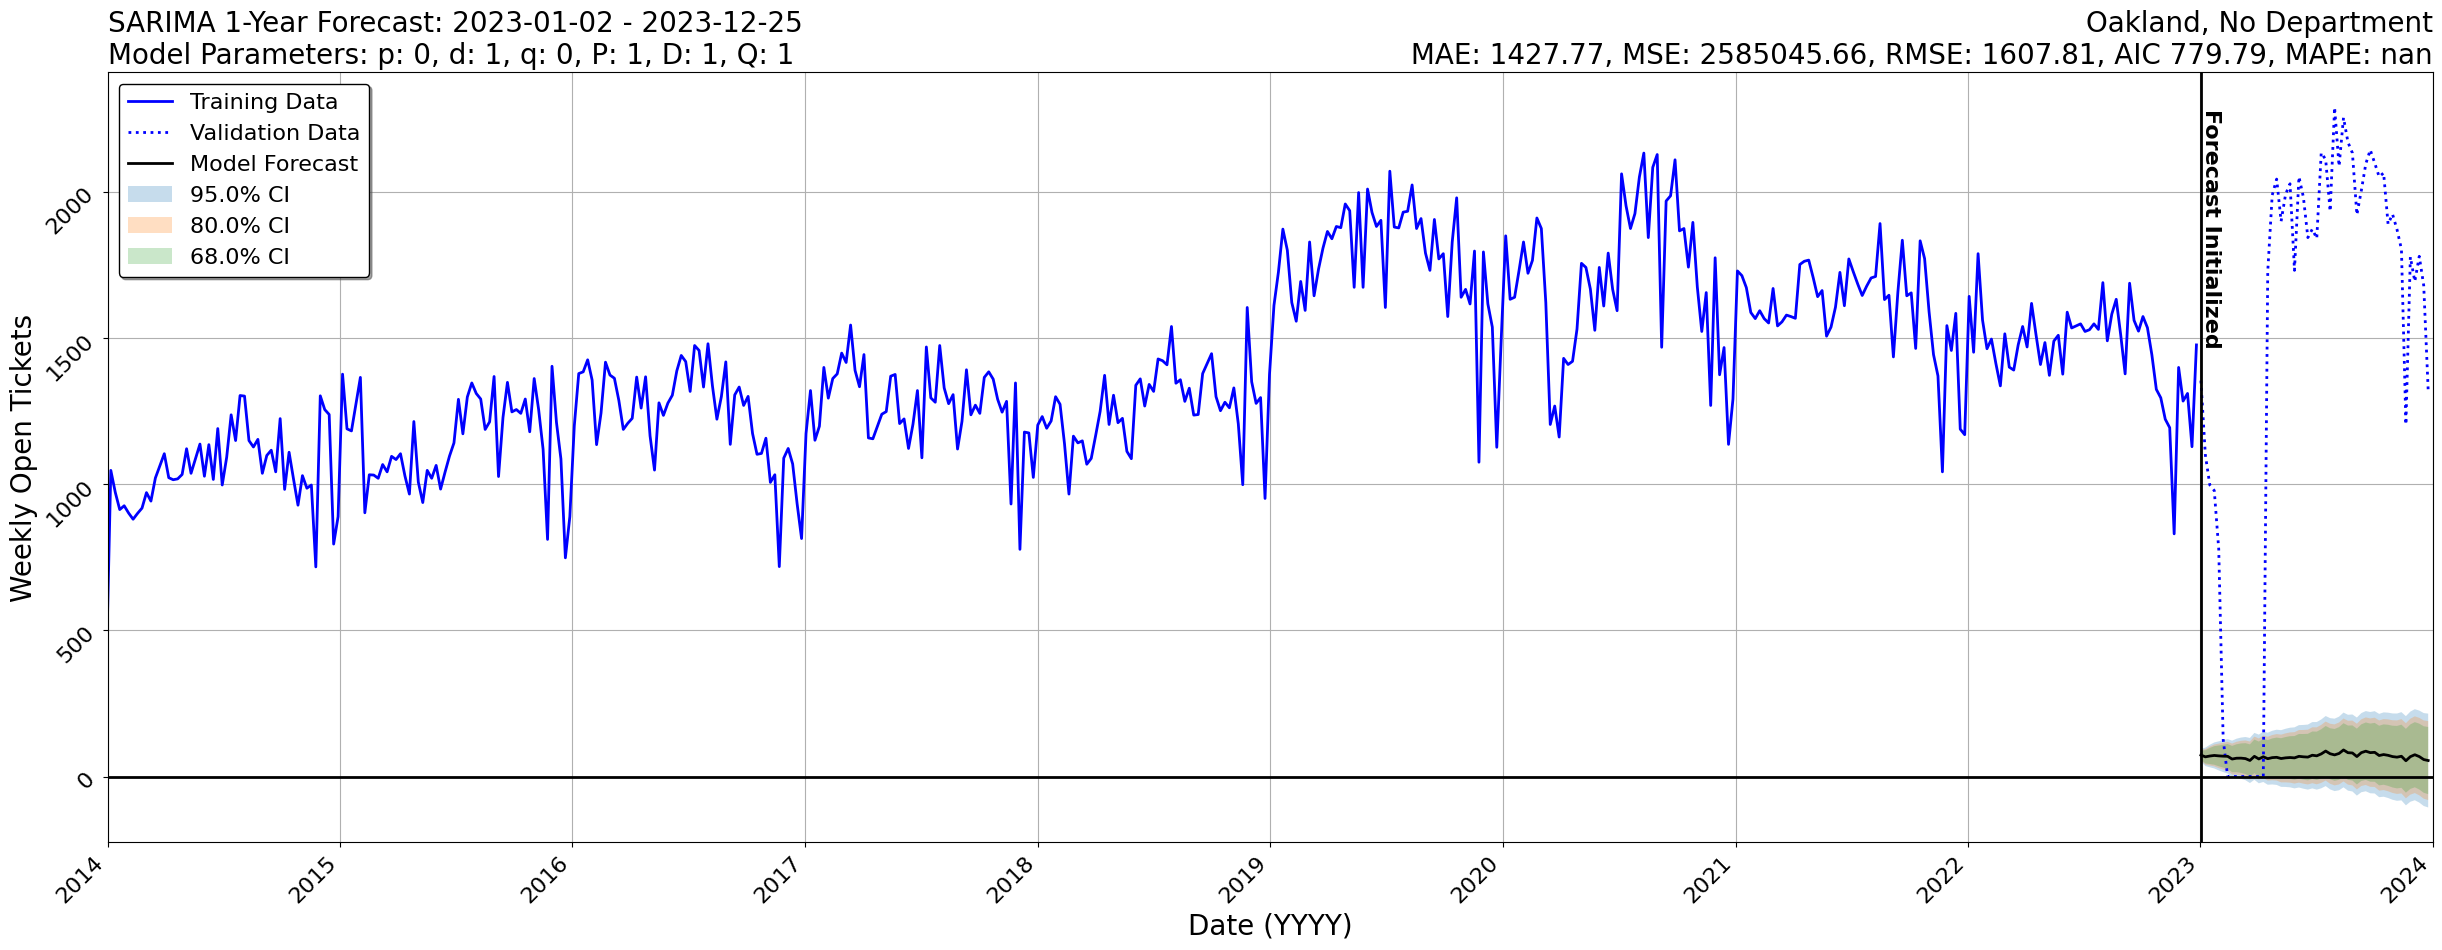

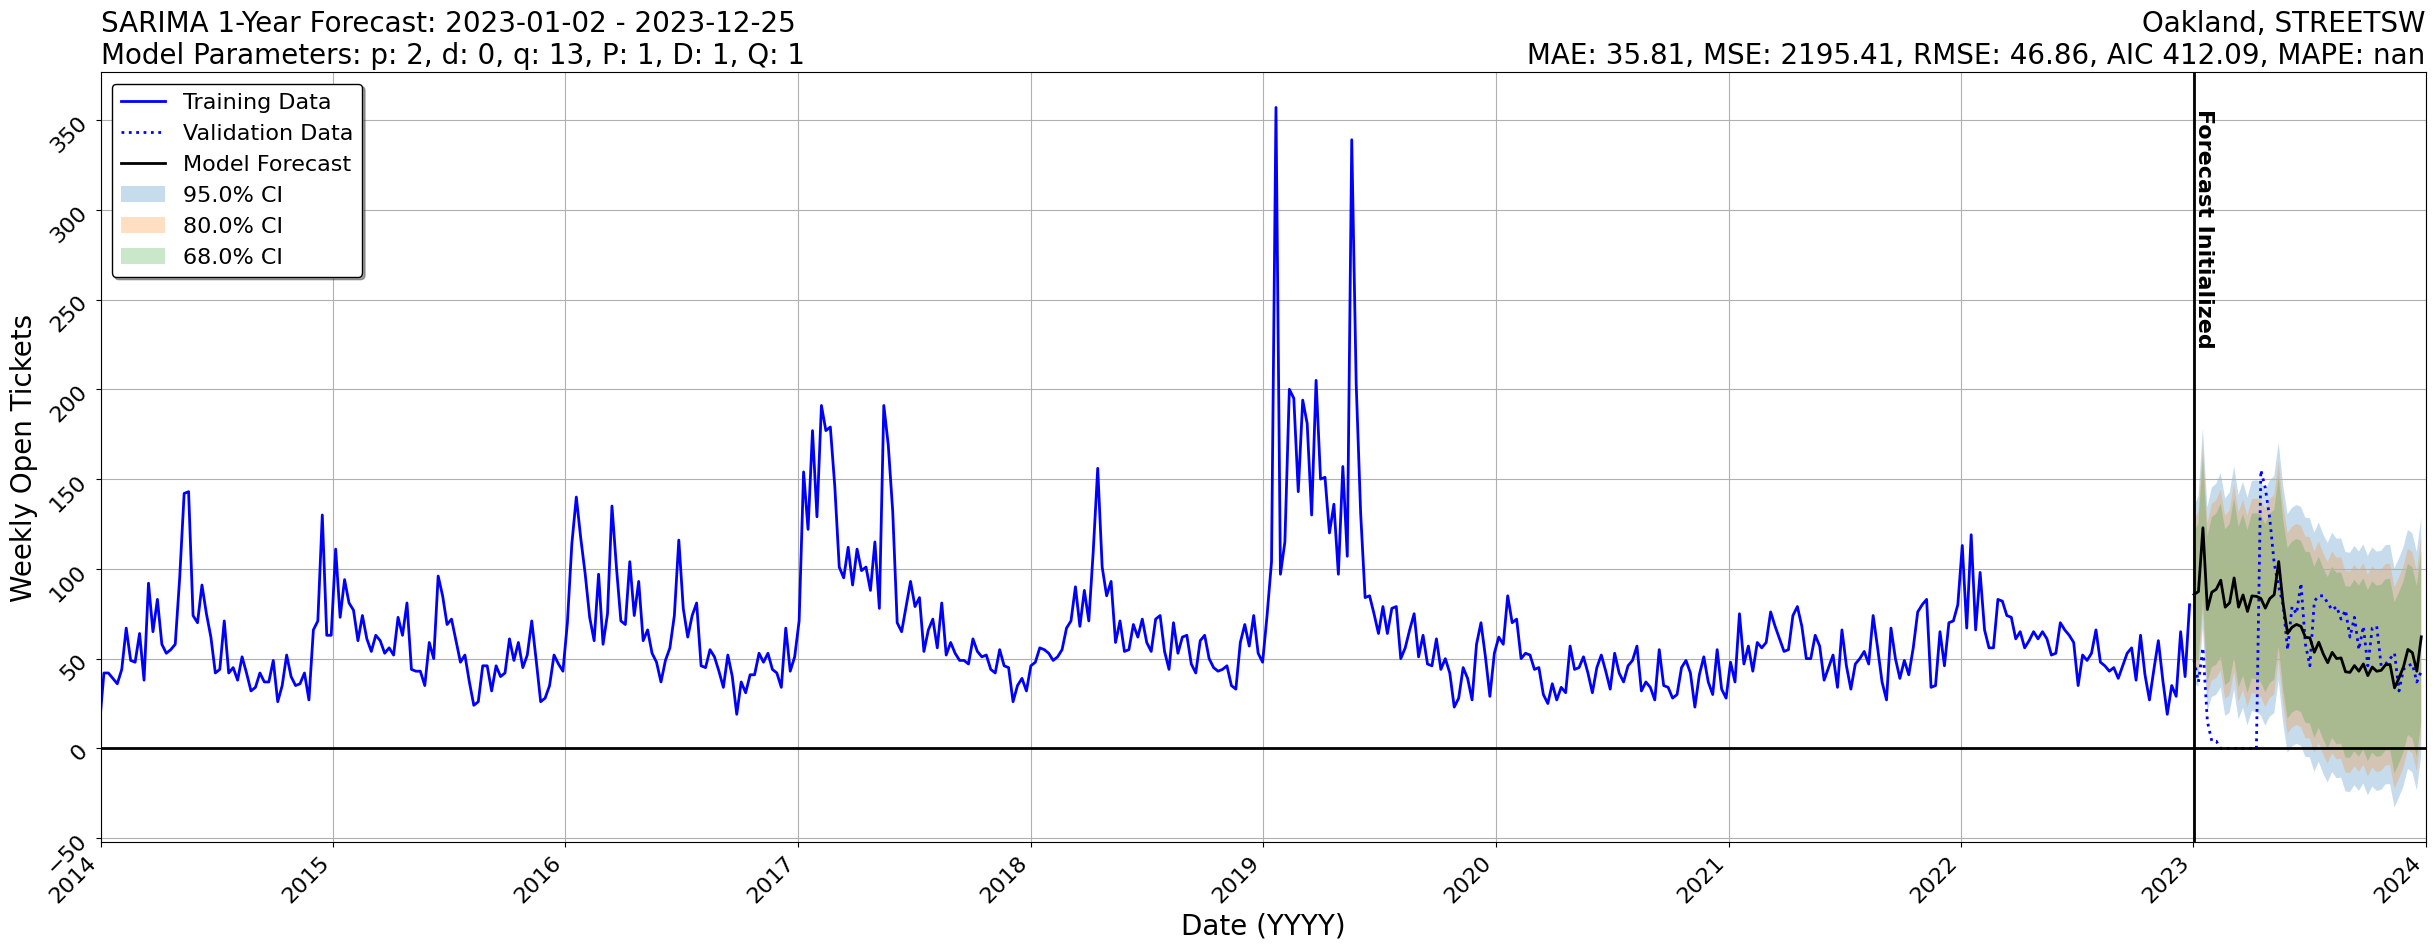

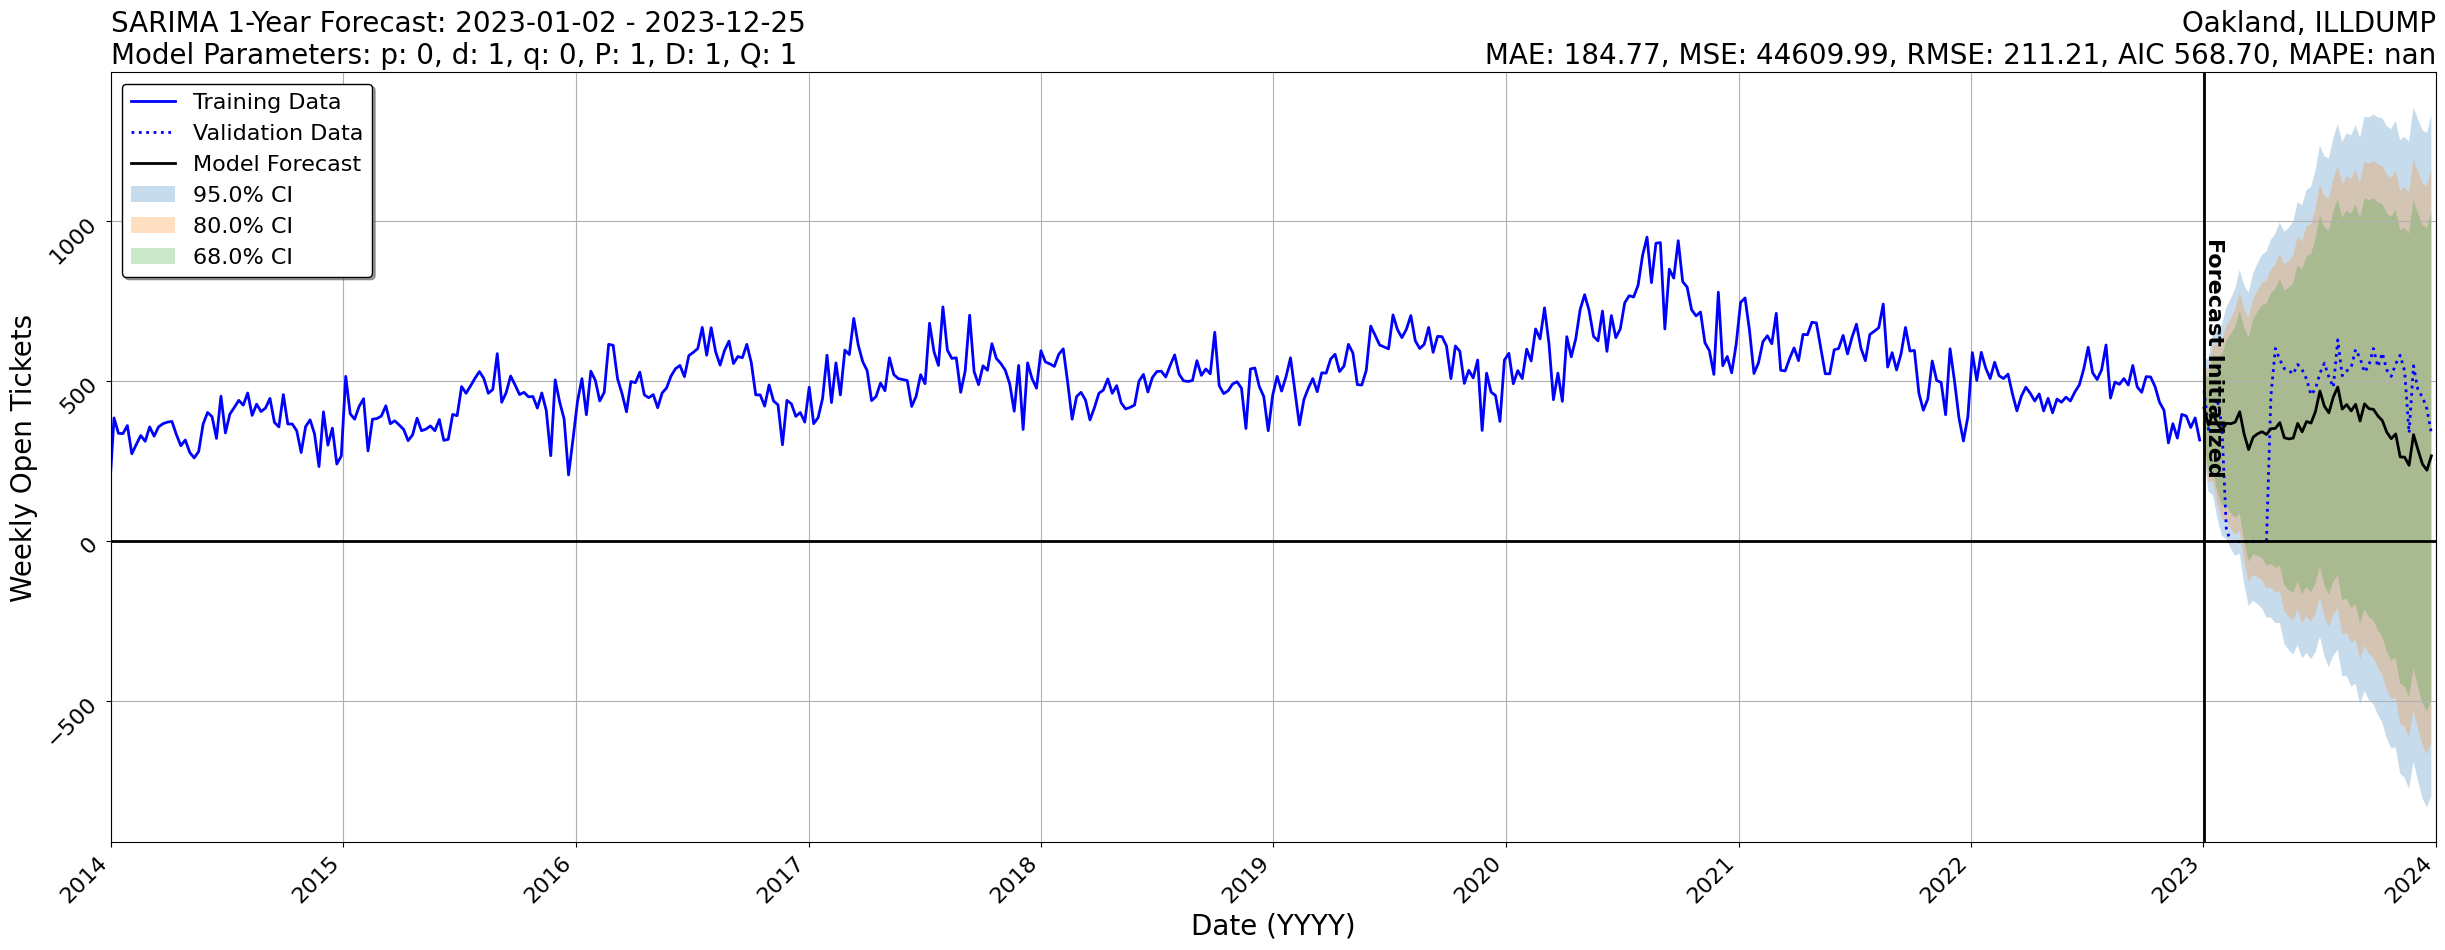

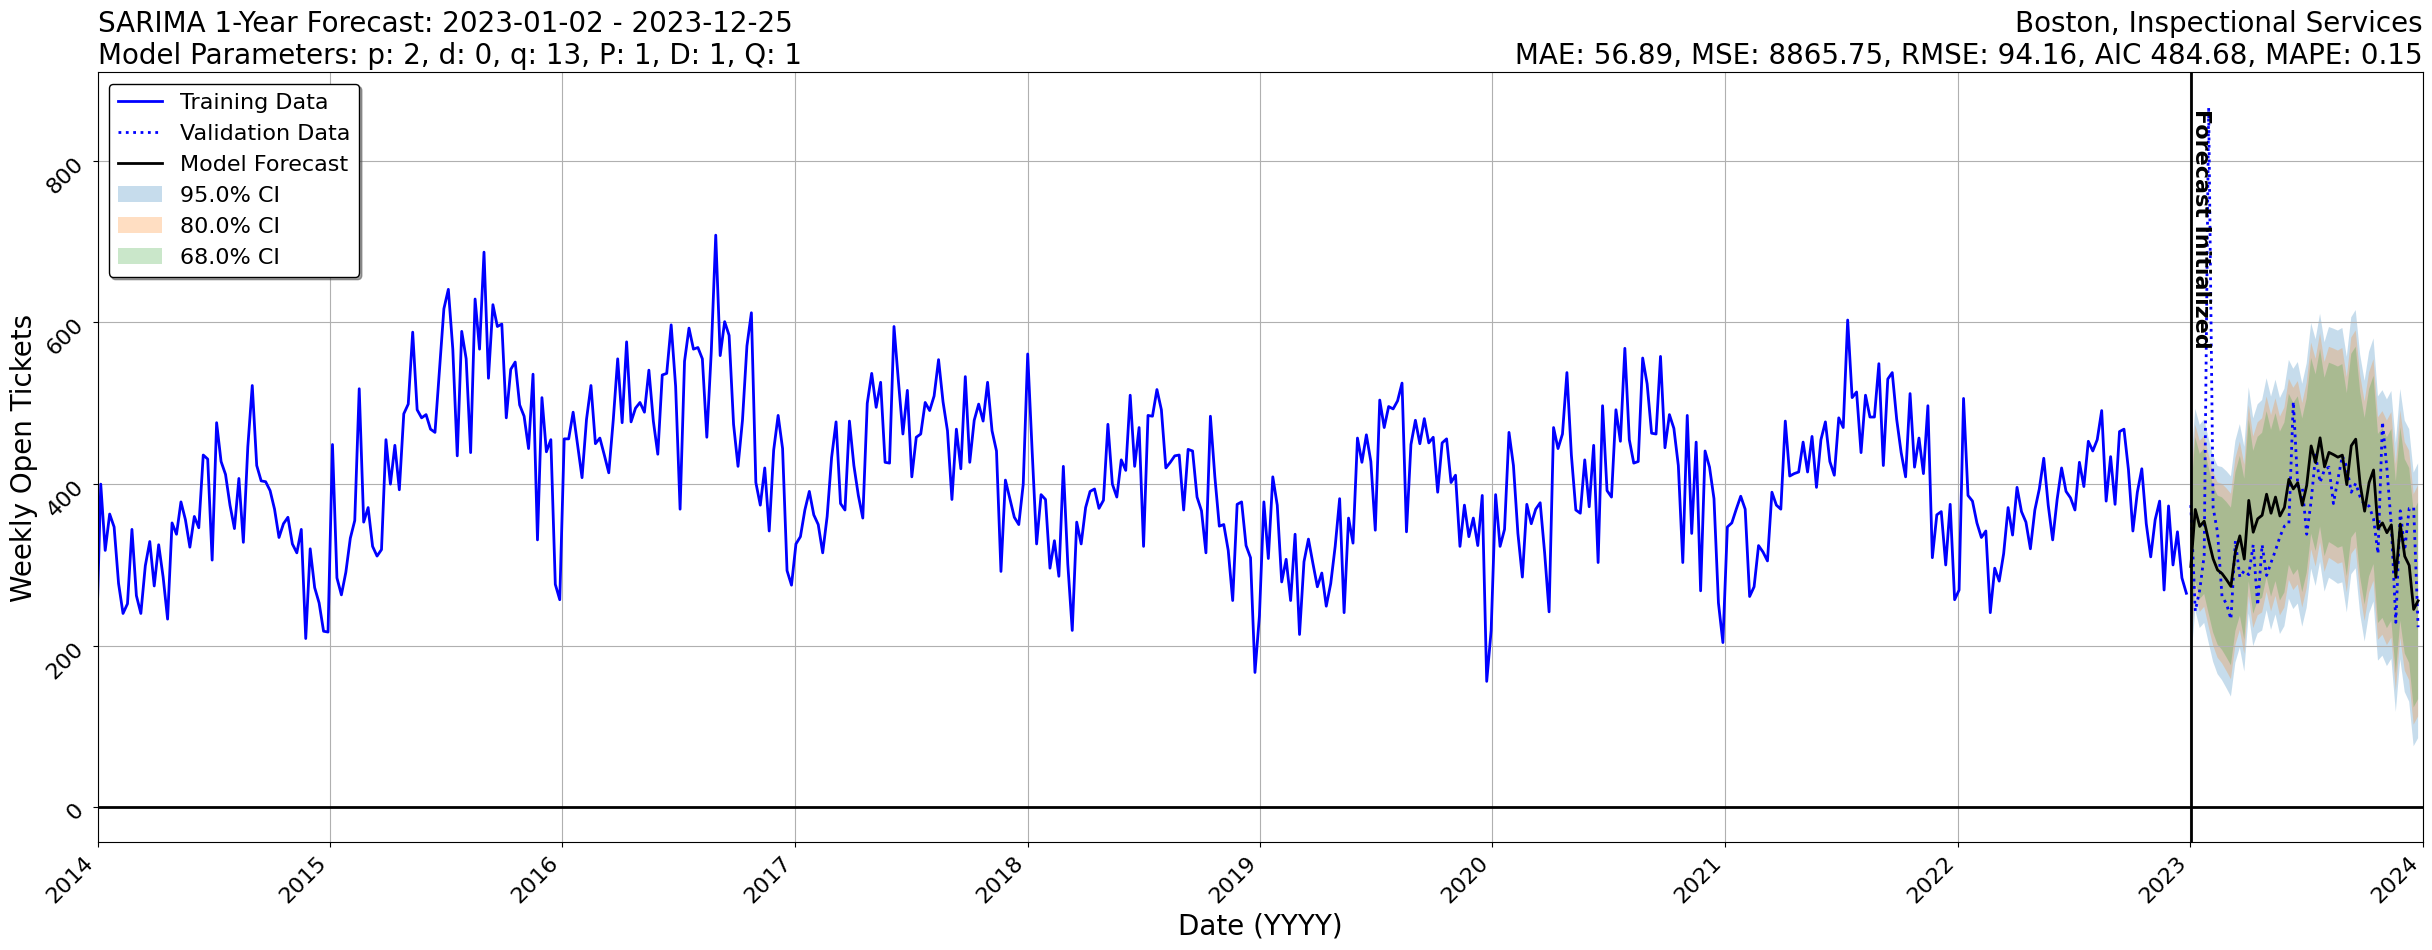

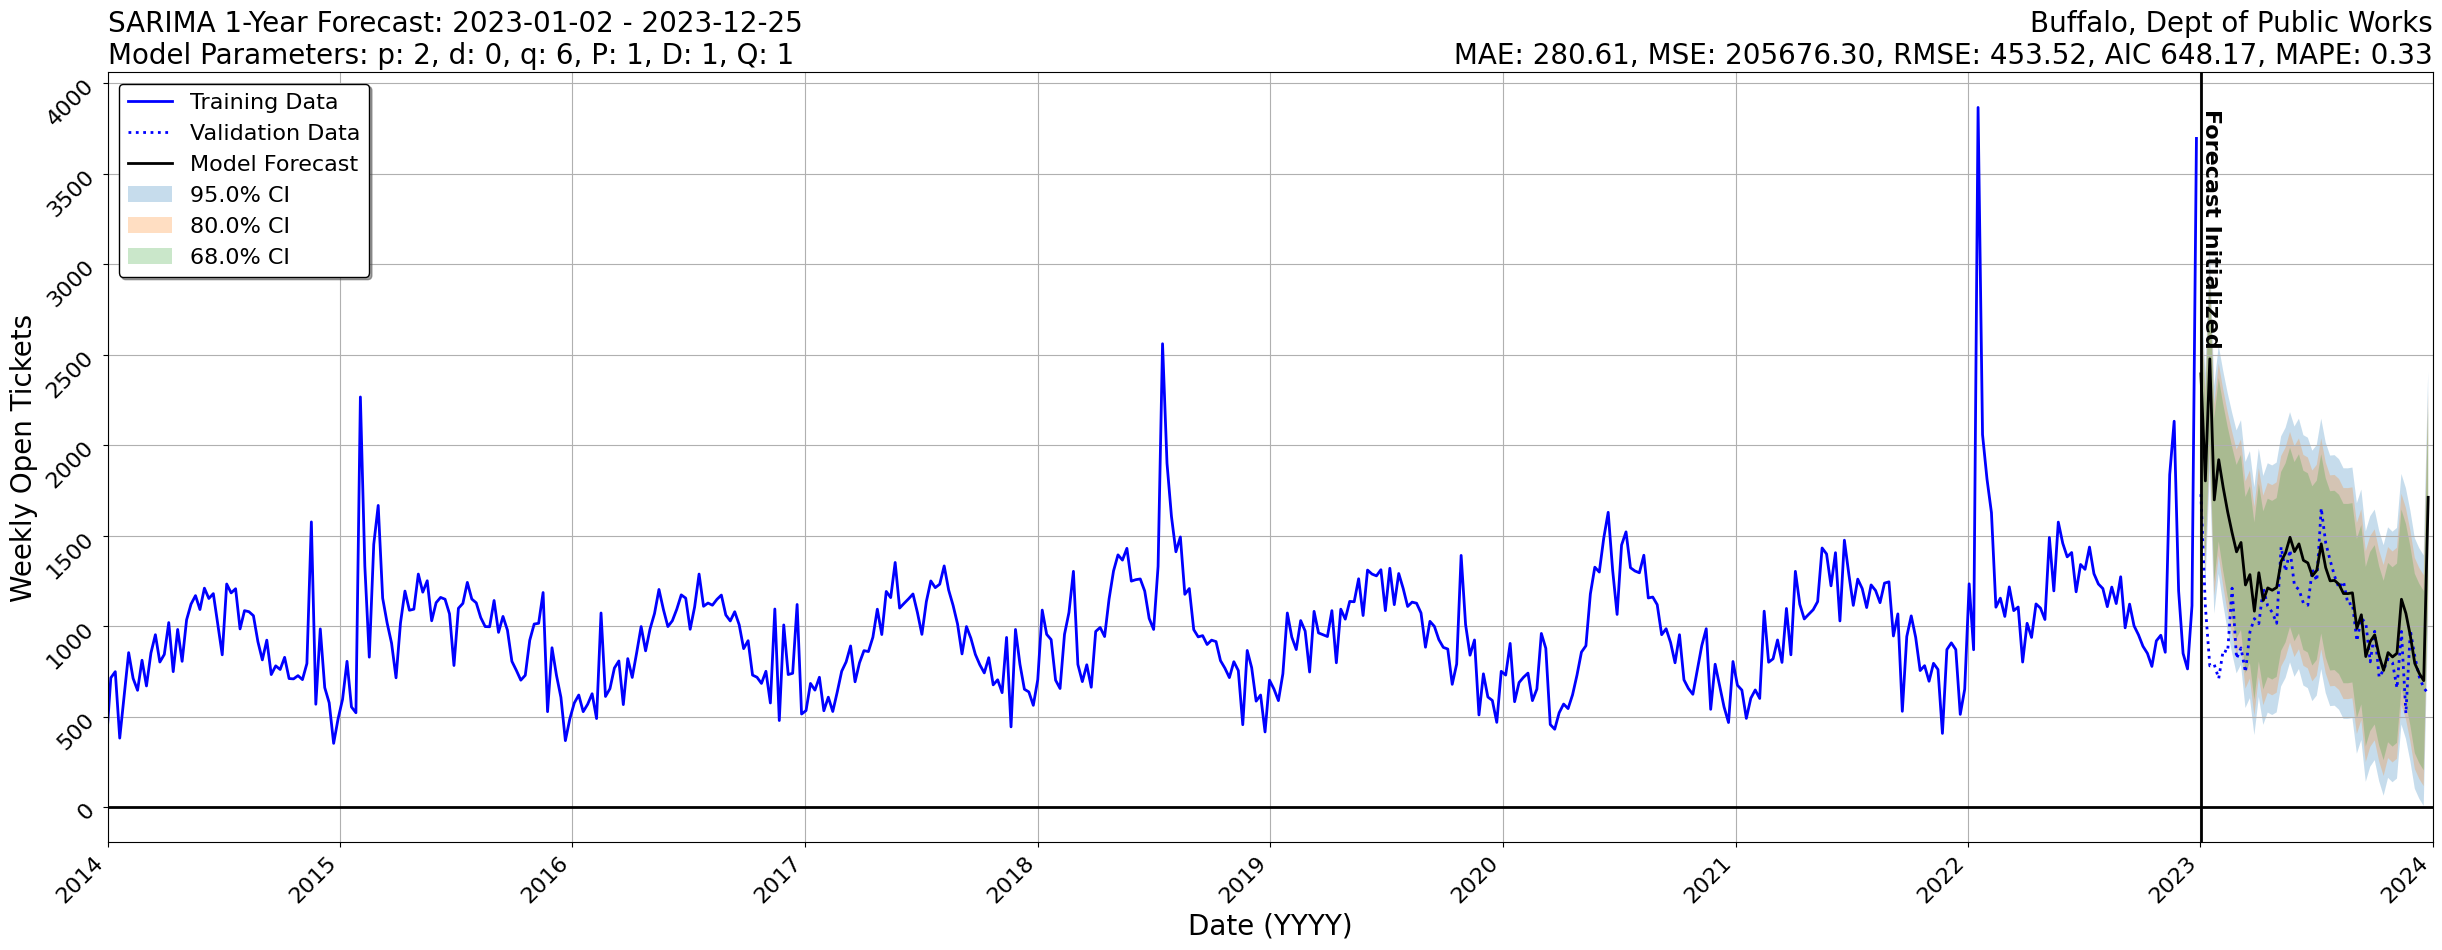

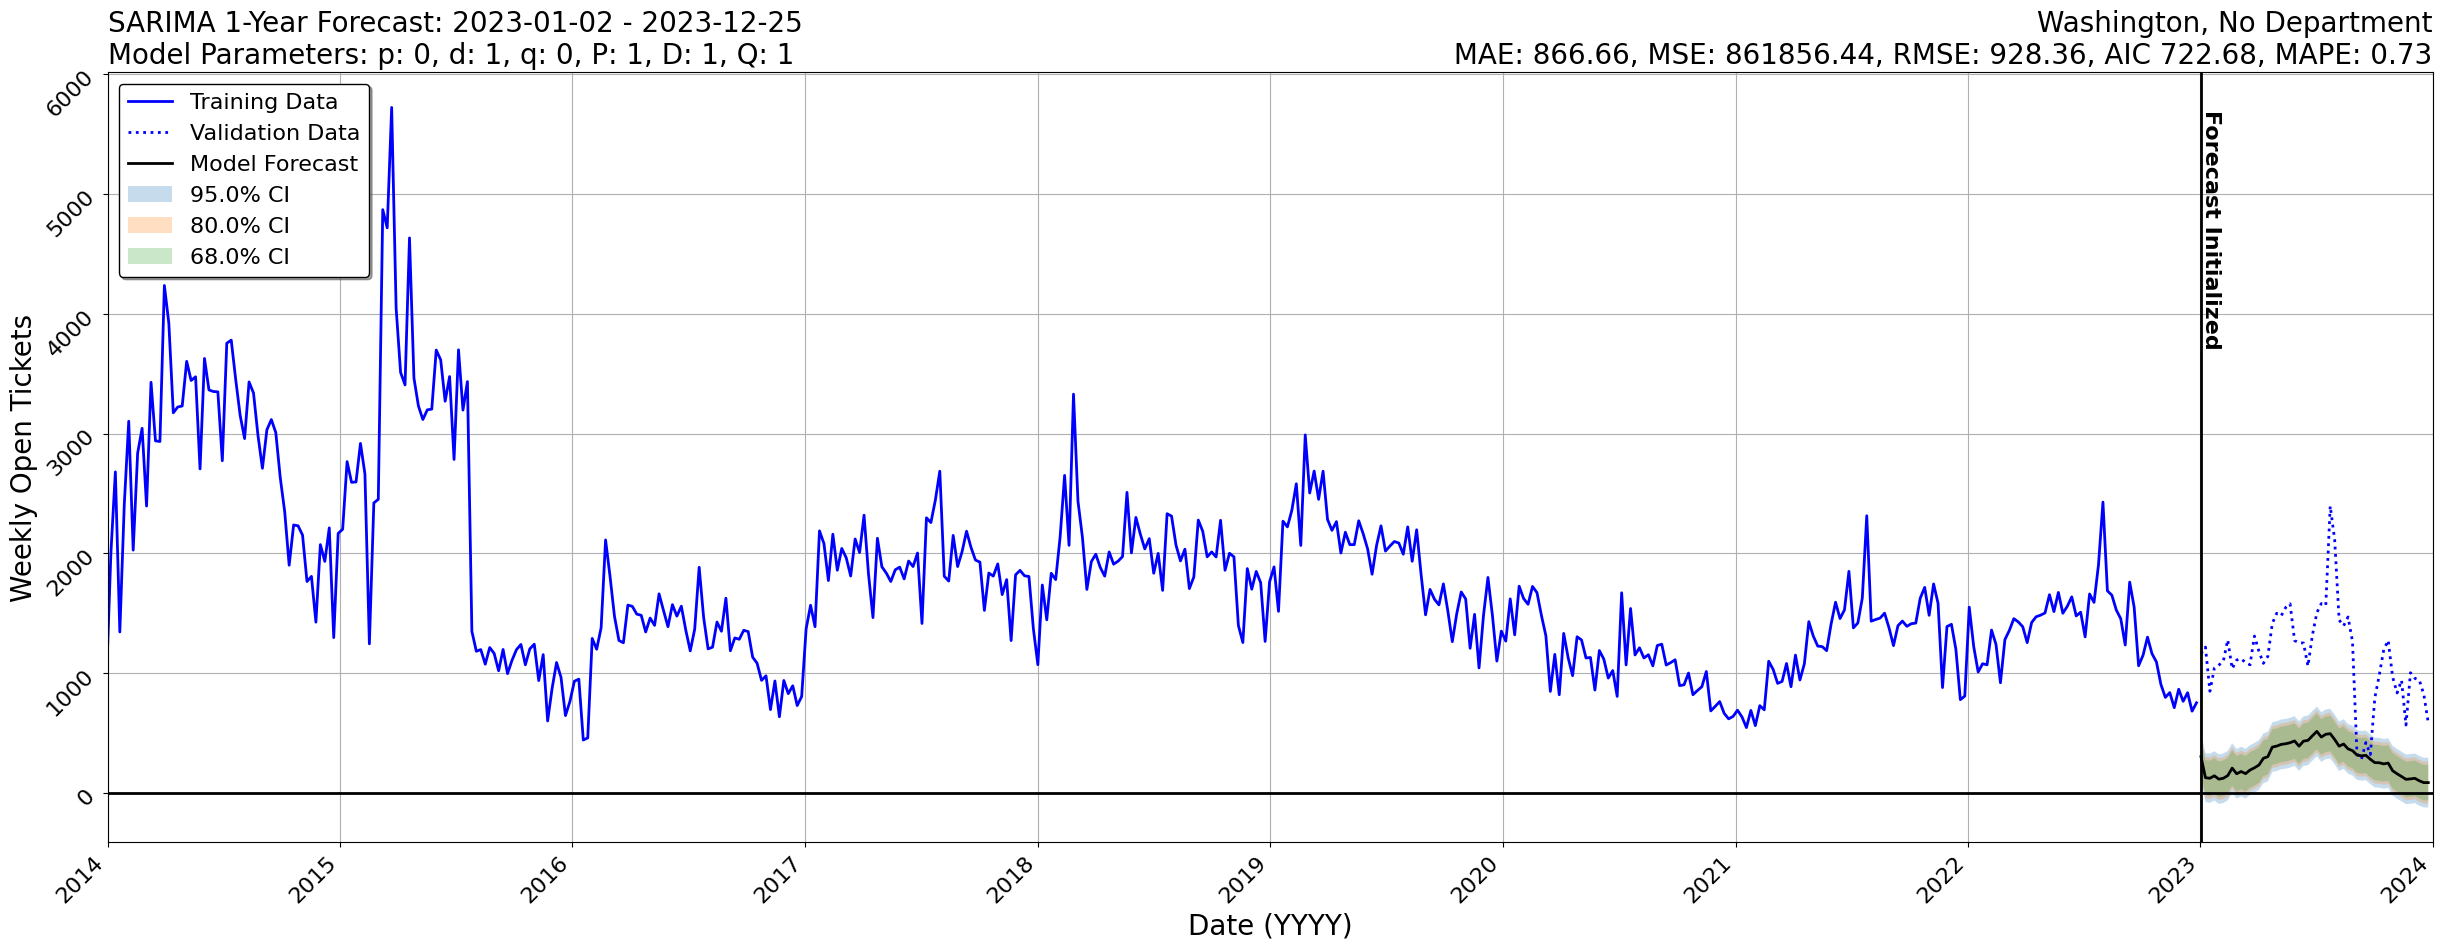

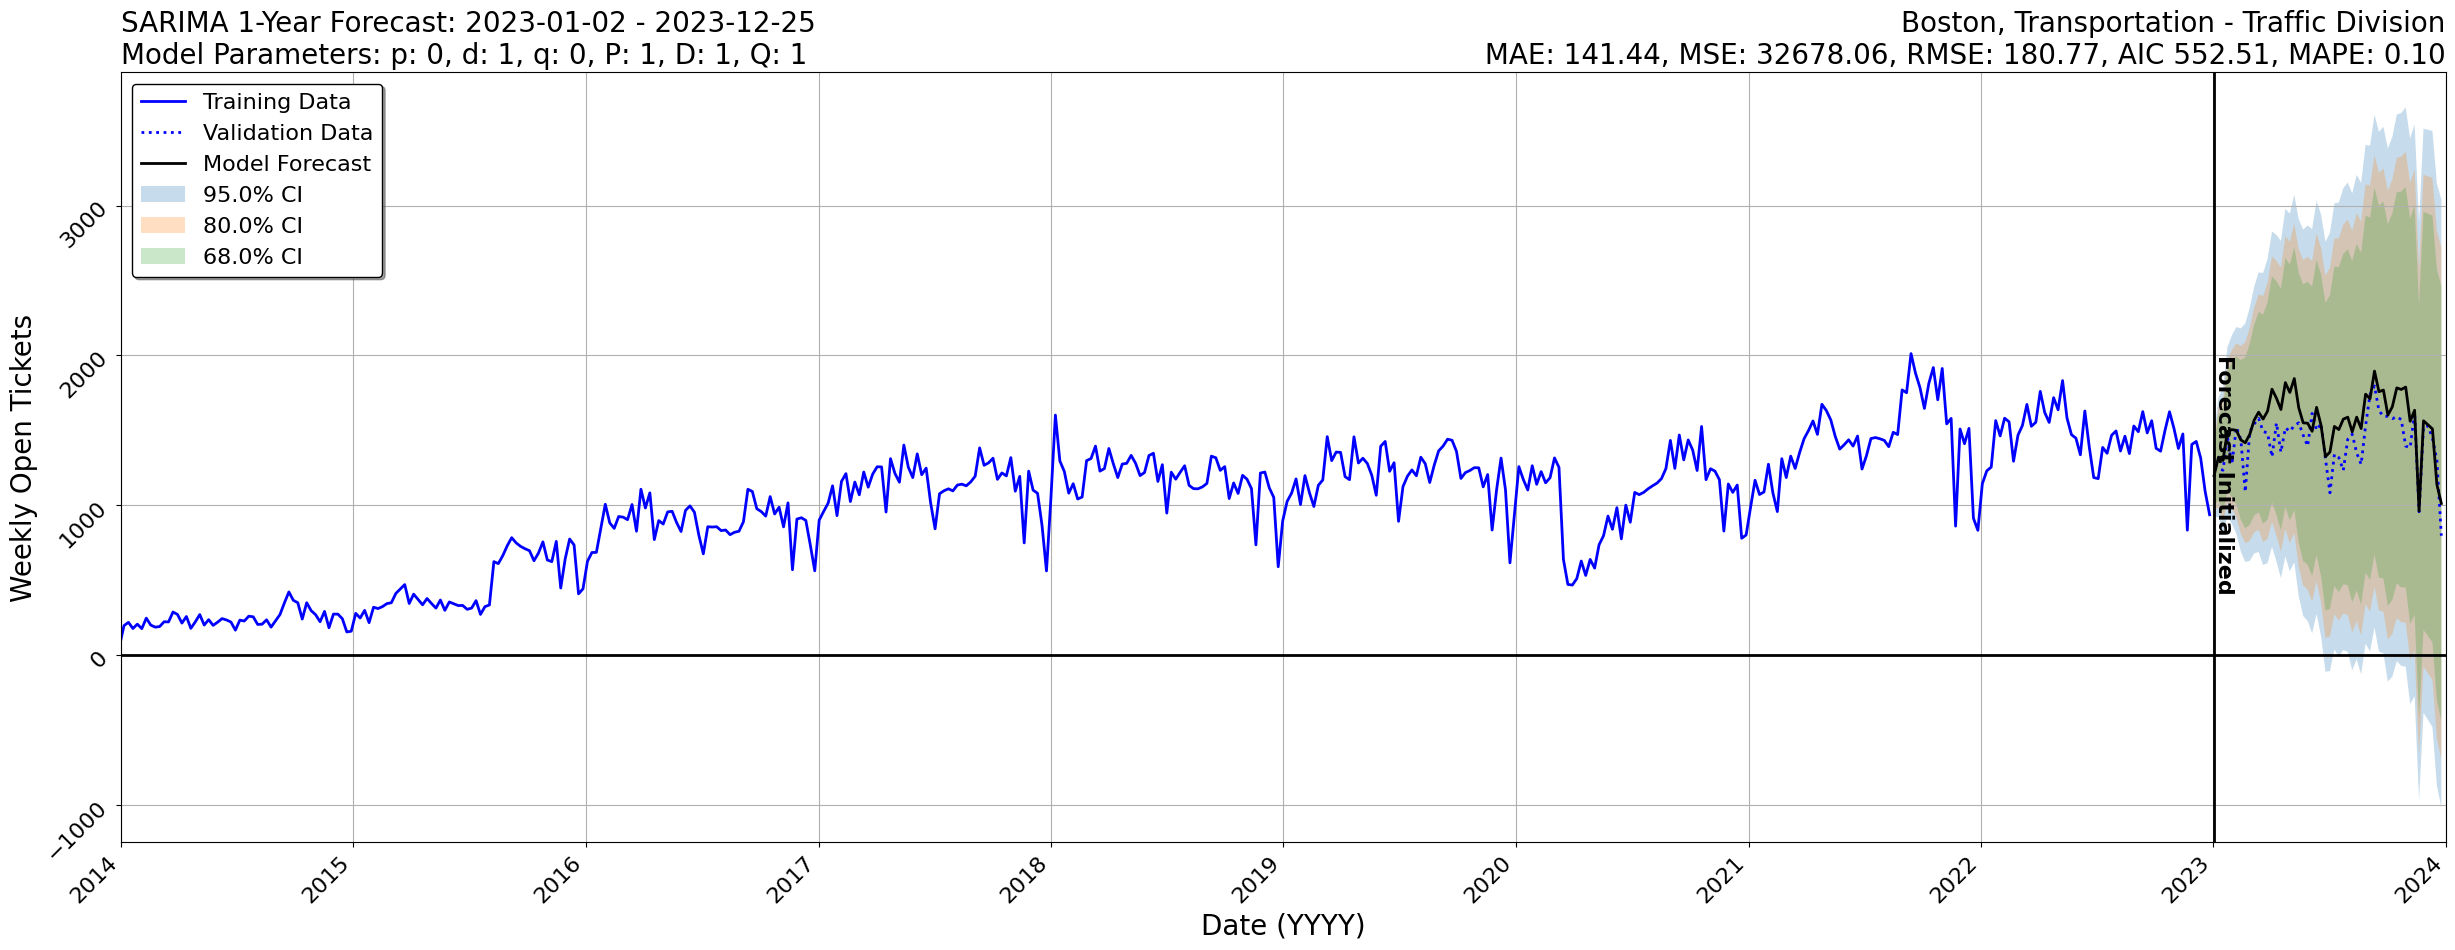

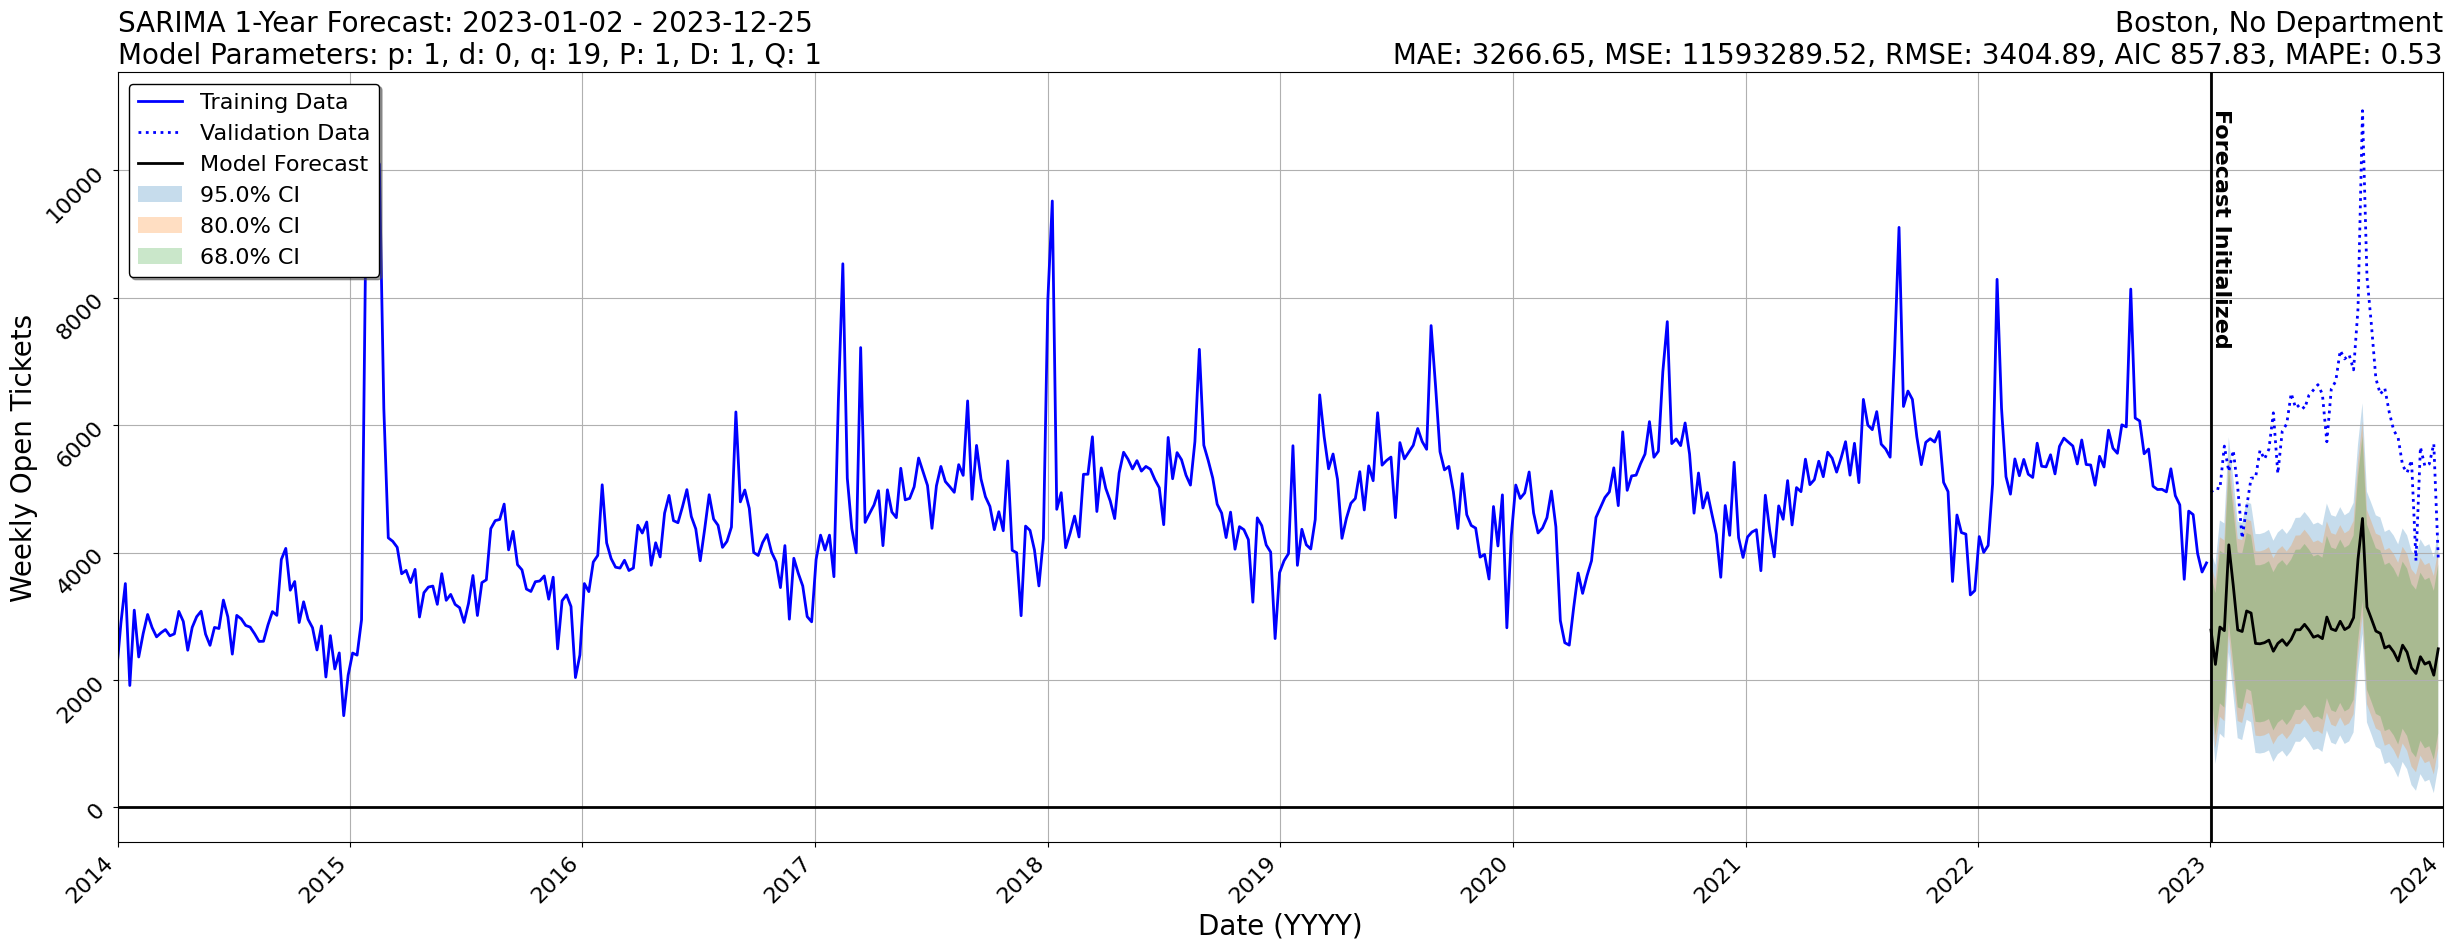

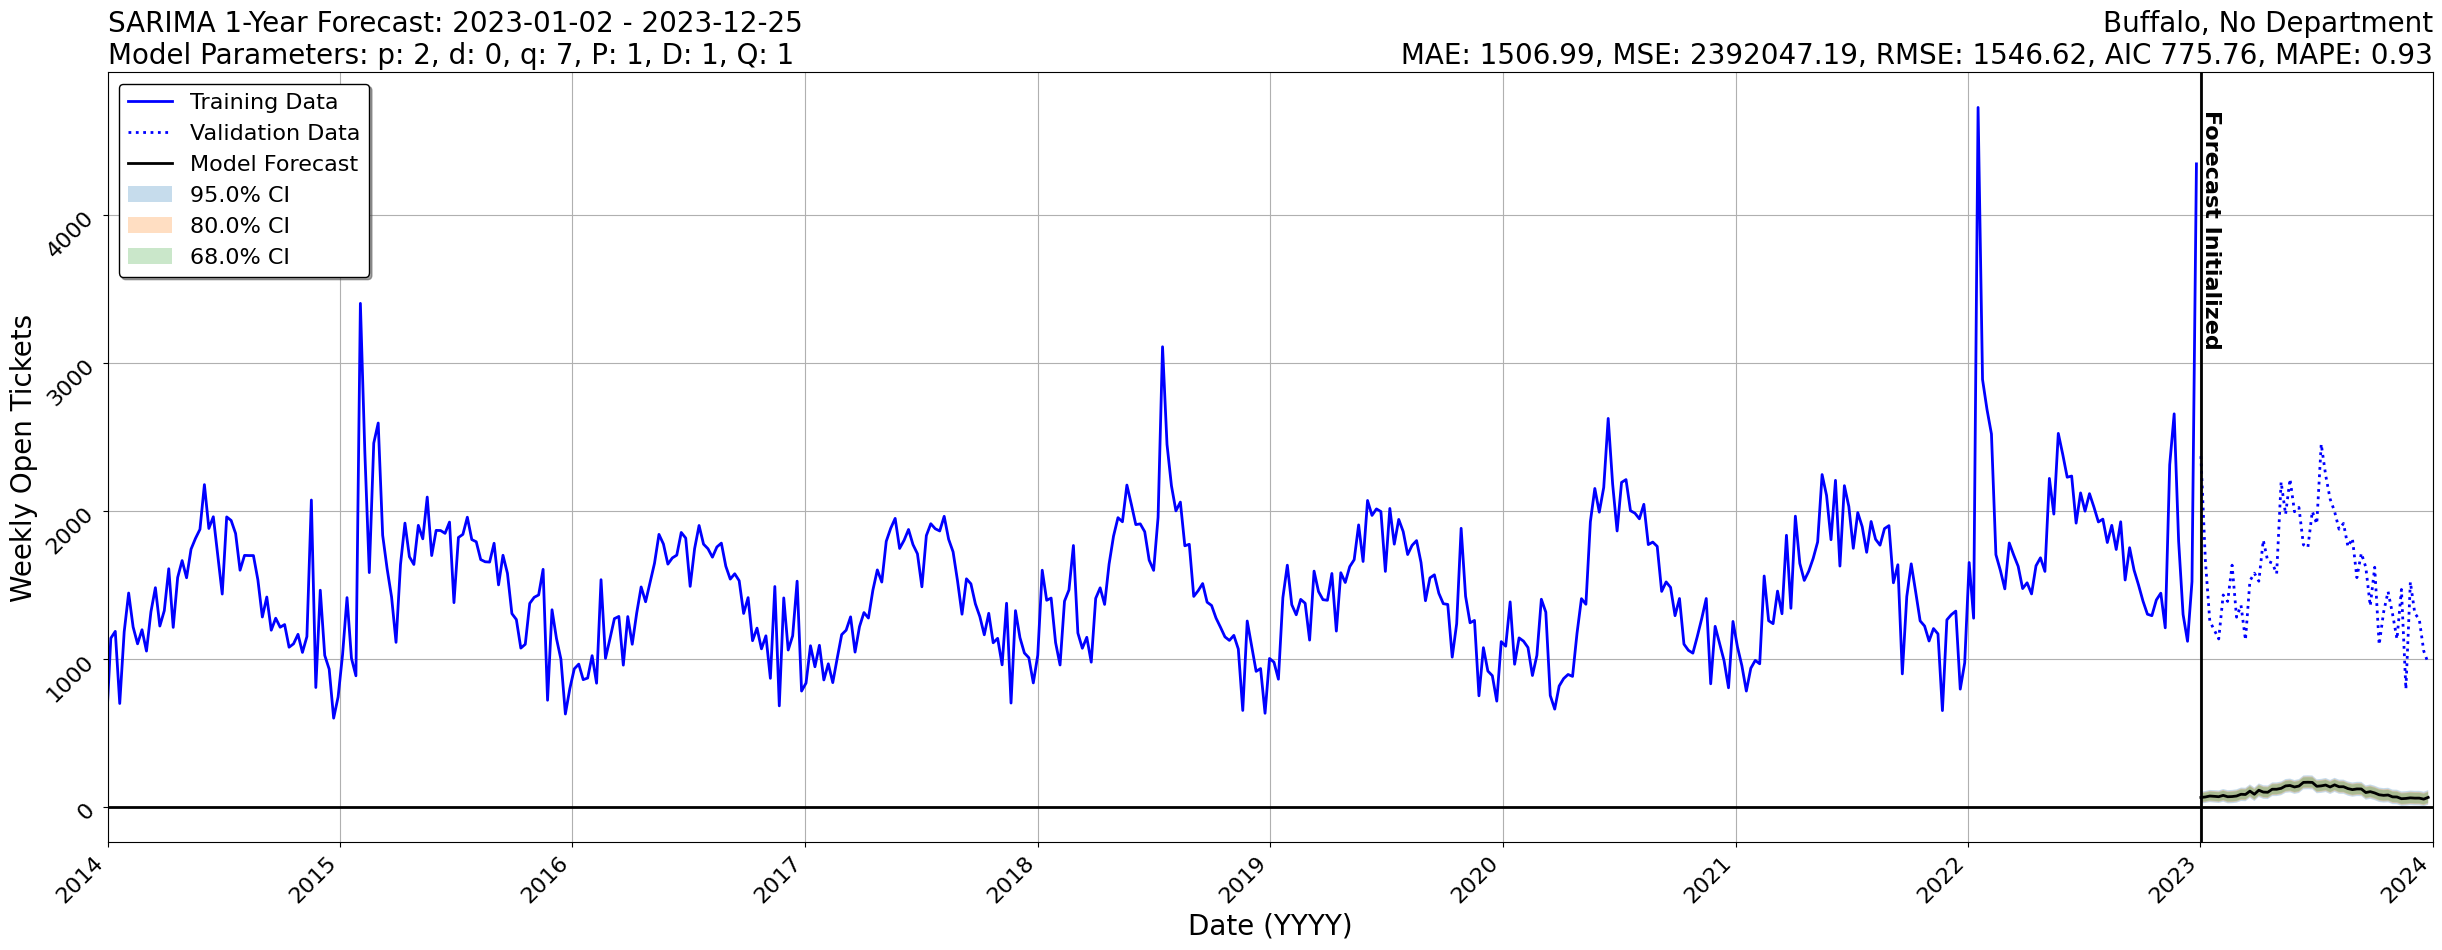

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Set the default size for plots
plt.rcParams['figure.figsize'] = (30.0, 10.0)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    rss = np.sum(resid ** 2)  # Residual sum of squares
    n = len(y_true)  # Number of observations
    aic = n * np.log(rss / n) + 2 * num_params  # AIC formula
    return aic

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  # Calculate RMSE

def compute_confidence_intervals(df, alpha_values=[0.05, 0.2, 0.32]):
    """
    Computes and returns confidence intervals at different alpha levels.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns for lower, upper, and forecast values.
        alpha_values (list): List of alpha values to compute confidence intervals for (e.g., 0.05 for 95% CI, 0.2 for 80% CI, and 0.32 for 68% CI).

    Returns:
        dict: Dictionary of DataFrames containing different confidence intervals.
    """
    intervals = {}

    for alpha in alpha_values:
        confidence_level = (1 - alpha) * 100  # Convert alpha to confidence level percentage

        # Compute interval bounds based on given alpha
        intervals[f'{confidence_level}% CI'] = pd.DataFrame({
            'lower': df['y_pred'] - (df['y_pred'] - df['lower count']) * (1 - alpha),
            'upper': df['y_pred'] + (df['upper count'] - df['y_pred']) * (1 - alpha),
        })

    return intervals

def plot_train_test_data(model_names, legend_font=14, title_font=20, label_font=16):
    # Function to plot training, test, and prediction data for different models

    metrics = []
    for model_name in model_names:
        # Split the model name to extract details
        model_name_split = model_name.split('_')
        if len(model_name_split) > 1:
            model_name_used = model_name_split[0]  # Use the first part if split results in more than one part
            model_name_none = model_name_split[1]  # Second part (often department name)
        else:
            model_name_used = model_name  # Use the entire model name if split results in only one part
            model_name_none = 'No Department'

        # Use glob to find corresponding files in directories
        train_file = glob(os.path.join('../data/out/', f'*{model_name}_train*.csv'))[0]
        test_file = glob(os.path.join('../data/out/', f'*{model_name}_test*.csv'))[0]
        pred_file = glob(os.path.join('../data/predictions/', f'*sarimax_{model_name}*.csv'))[0]
        model_file = glob(os.path.join('../models/', 'hyperparameters.csv'))[0]

        # Load model hyperparameters
        model_data = pd.read_csv(model_file)
        model_params = model_data[model_data['model_name'] == model_name]
        p, d, q, P, D, Q = model_params[['p', 'd', 'q', 'P', 'D', 'Q']].values[0]

        # Load training, test, and prediction data
        train_data = pd.read_csv(train_file)
        train_data['week_start'] = pd.to_datetime(train_data['week_start'])
        test_data = pd.read_csv(test_file)
        test_data['week_start'] = pd.to_datetime(test_data['week_start'])
        pred_data = pd.read_csv(pred_file)
        pred_data['week_start'] = pd.to_datetime(pred_data['week_start'])

        # Formatting date range for title
        start_date = pred_data.week_start.iloc[0].strftime('%Y-%m-%d')
        end_date = pred_data.week_start.iloc[-1].strftime('%Y-%m-%d')

        # Calculate error metrics
        mae = mean_absolute_error(test_data['count'], pred_data['y_pred'])
        mse = mean_squared_error(test_data['count'], pred_data['y_pred'])
        rmse = calculate_rmse(test_data['count'], pred_data['y_pred'])
        num_params = len(model_params.columns) - 1  # Exclude 'model_name' column
        aic = calculate_aic(test_data['count'], pred_data['y_pred'], num_params)
        mape = mean_absolute_percentage_error(test_data['count'], pred_data['y_pred']) if 0 not in test_data['count'].values else np.nan
        metrics.append((model_name, mae, mse, rmse, aic, mape))

        # Plot data
        plt.plot(train_data['week_start'], train_data['count'], label='Training Data', c='b', linewidth=2)
        plt.plot(test_data['week_start'], test_data['count'], label='Validation Data', c='b', linestyle=':', linewidth=2)
        plt.plot(pred_data['week_start'], pred_data['y_pred'], label='Model Forecast', c='k', linewidth=2)# linestyle = '')

        # Vertical line to indicate start of validation data
        plt.axvline(x=pred_data['week_start'].iloc[0], c='k', linewidth=2)
        plt.axhline(y=0, c='k', linewidth=2)
        plt.text(pred_data['week_start'].iloc[0], plt.ylim()[1]*0.95, 'Forecast Initialized', rotation=270, verticalalignment='top', color='k', fontweight='heavy', fontsize=16)

        # Compute confidence intervals for 95%, 80%, and 68% levels & Plot confidence intervals
        intervals = compute_confidence_intervals(pred_data, alpha_values=[0.05, 0.2, 0.32])
        for ci_label, ci_data in intervals.items():
            plt.fill_between(test_data['week_start'], ci_data['lower'], ci_data['upper'], alpha=0.25, label=ci_label)

        # Titles and labels
        plt.title(f'SARIMA 1-Year Forecast: {start_date} - {end_date}\nModel Parameters: p: {p}, d: {d}, q: {q}, P: {P}, D: {D}, Q: {Q}', fontsize=title_font, fontweight='normal', loc='left')
        plt.title(f'{model_name_used.capitalize()}, {model_name_none}\n MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, AIC {aic:.2f}, MAPE: {mape:.2f}', fontsize=title_font, fontweight='normal', loc='right')
        plt.xlabel('Date (YYYY)', fontsize=label_font + 4)
        plt.ylabel('Weekly Open Tickets', fontsize=label_font + 4)
        plt.xticks(rotation=45, ha='right', fontsize=label_font)
        plt.yticks(rotation=45, ha='right', fontsize=label_font)
        plt.xlim(pd.Timestamp('2014-01-01'), pd.Timestamp('2024-01-01'))
        
        # Display legend and grid
        plt.legend(loc='upper left', frameon=True, fontsize=legend_font + 2, shadow=True, edgecolor='black')
        plt.grid(True)
        plt.show()
    return pd.DataFrame(metrics, columns=['Model', 'MAE', 'MSE', 'RMSE', 'AIC', 'MAPE']).set_index('Model')

# Example usage:
model_names = ['buffalo_Buffalo Police Department',
    'oakland_PARKING',
    'buffalo_DPIS',
    'washington_UFA',
    'washington_TOA-CW',
    'washington_TOA-S&M',
    'boston_Public Works Department',
    'oakland',
    'oakland_STREETSW',
    'oakland_ILLDUMP',
    'boston_Inspectional Services',
    'buffalo_Dept of Public Works',
    'washington',
    'boston_Transportation - Traffic Division',
    'boston',
    'buffalo']
metrics = plot_train_test_data(model_names)


In [19]:
display(metrics)

MAE           MSE  \
Model                                                                 
buffalo_Buffalo Police Department           26.686938  1.431245e+03   
oakland_PARKING                             32.909744  1.410531e+03   
buffalo_DPIS                                25.690096  1.143641e+03   
washington_UFA                              98.894624  3.076517e+04   
washington_TOA-CW                           66.741734  6.260826e+03   
washington_TOA-S&M                          82.166549  1.000607e+04   
boston_Public Works Department             840.947759  1.001811e+06   
oakland                                   1427.766677  2.585046e+06   
oakland_STREETSW                            35.805644  2.195408e+03   
oakland_ILLDUMP                            184.768305  4.460999e+04   
boston_Inspectional Services                56.885316  8.865747e+03   
buffalo_Dept of Public Works               280.609025  2.056763e+05   
washington                                 866.656859  8.618564e+05   
boston_Transportation - Traffic Division   141.437842  3.267806e+04   
boston                                    3266.650309  1.159329e+07   
buffalo                                   1506.990897  2.392047e+06   

                                                 RMSE         AIC      MAPE  
Model                                                                        
buffalo_Buffalo Police Department           37.831794  389.847587  0.242034  
oakland_PARKING                             37.557040  389.089528       NaN  
buffalo_DPIS                                33.817765  378.182570  0.147694  
washington_UFA                             175.400041  549.375209  0.616379  
washington_TOA-CW                           79.125384  466.587509  0.373741  
washington_TOA-S&M                         100.030346  490.969254  0.377548  
boston_Public Works Department            1000.904890  730.500615  0.226564  
oakland                                   1607.807717  779.793194       NaN  
oakland_STREETSW                            46.855180  412.094402       NaN  
oakland_ILLDUMP                            211.210775  568.697083       NaN  
boston_Inspectional Services                94.158098  484.677428  0.153396  
buffalo_Dept of Public Works               453.515495  648.171062  0.326464  
washington                                 928.362238  722.675888  0.728540  
boston_Transportation - Traffic Division   180.770732  552.511874  0.104297  
boston                                    3404.891998  857.828724  0.534018  
buffalo                                   1546.624449  775.758326  0.934896